Here we study how number of pairs and their dissimilarity change with the sky area of lenses.

In [1]:
# Standard imports
import copy
import corner
import numpy as np
from tqdm import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt
from itertools import combinations
from IPython.display import display, Markdown, Math
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import norm
from scipy.optimize import curve_fit

# Astropy imports
from astropy.io import fits
from astropy import units as u
from astropy.table import Table
from astropy.units import Quantity
from astropy import constants as const
from astropy.cosmology import FlatLambdaCDM

# SLSim imports
import slsim.Pipelines as pipelines
import slsim.Sources as sources
import slsim.Deflectors as deflectors
from slsim.Lenses.lens_pop import LensPop
from slsim.Plots.lens_plots import LensingPlots
from slsim.Lenses.lens import Lens
from slsim.LOS.los_pop import LOSPop

# Lenstronomy, HierArc imports
from lenstronomy.LensModel.lens_model import LensModel
from hierarc.Sampling.ParamManager.cosmo_param import CosmoParam
from utils import kdtree_matching_n_dim, get_pairs_table_PDSPL, normalize_data

plt.style.use("paper_style.mplstyle")

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-068 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-071
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf
/Users/paras/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/paras/Projects/repos/self/slsim/slsim/Plots/lens_plots.py:5: UserWarning: If you want to simulate images with Roman filters, please install the galsim module.
Note that this module is not supported on Windows
  from slsim.ImageSimulation.roman_image_simulation import simulate_roman_image


## Prepare LSST like samples for Single Visit, Y10, and 4MOST 

In [2]:
########################################################
### Load the GGL data table and apply selection cuts!
########################################################

sky_area = "20000.0"
GGL_data_table = Table.read(f"../data/FULL_LSST/GGL_{sky_area}_SQDEG_NON_SIS.fits", format='fits')
# GGL_data_table = Table.read(f"../data/FULL_LSST/GGL_{sky_area}_SQDEG_NON_SIS_UNIQUE_DEFLECTORS.fits", format='fits')

contrast_mask = np.zeros(len(GGL_data_table), dtype=bool)
# ps_magnification_mask = np.zeros(len(GGL_data_table), dtype=bool)
for i in range(len(GGL_data_table)):
    
    # contrast mask
    all_vals = GGL_data_table['contrast_ratio_i'][i]
    all_vals = all_vals[~np.isnan(all_vals)]
    # get linear scale values
    all_vals = 10**(-0.4 * all_vals)
    contrast_mask[i] = np.all(all_vals > 2) # all images should have contrast ratio > 2

    # point source magnification mask
    # ps_magnifications = GGL_data_table['ps_magnification'][i]
    # ps_magnifications = ps_magnifications[~np.isnan(ps_magnifications)]
    # high_mag = np.any(np.abs(ps_magnifications) > 3)
    # ps_magnification_mask[i] = high_mag

# add a column for r_band lensed source magnitude
GGL_data_table['mag_S_r_lensed'] = GGL_data_table['mag_S_r'] - 2.5 * np.log10(np.abs(GGL_data_table['es_magnification']))
GGL_data_table['mag_S_i_lensed'] = GGL_data_table['mag_S_i'] - 2.5 * np.log10(np.abs(GGL_data_table['es_magnification']))

# add g-r and r-i colors for deflector
GGL_data_table['color_D_gr'] = GGL_data_table['mag_D_g'] - GGL_data_table['mag_D_r']
GGL_data_table['color_D_ri'] = GGL_data_table['mag_D_r'] - GGL_data_table['mag_D_i']

# add log columns
GGL_data_table['log_R_e_kpc'] = np.log10(GGL_data_table['R_e_kpc'])
GGL_data_table['log_Sigma_half_Msun/pc2'] = np.log10(GGL_data_table['Sigma_half_Msun/pc2'])
GGL_data_table['log_sigma_v_D'] = np.log10(GGL_data_table['sigma_v_D'])

GGL_data_table = GGL_data_table[ 
                                # (GGL_data_table['mag_D_i'] >= 19) & # optional, but reasonable for realistic deflectors
                                (GGL_data_table['mag_S_i_lensed'] < 28)
                                & (GGL_data_table['mag_D_i'] < 28)
                                & (contrast_mask)
                                & (np.abs(GGL_data_table['es_magnification']) > 3)
                                # & (ps_magnification_mask)
                                ]

# remove duplicates
# GGL_data_table = GGL_data_table[np.unique(GGL_data_table['z_D'], return_index=True)[1]]

GGL_data_table

<Table length=322403>
lens_id         z_D         ... log_Sigma_half_Msun/pc2   log_sigma_v_D   
 int64        float64       ...         float64              float64      
------- ------------------- ... ----------------------- ------------------
      0   0.329124822435322 ...      3.9312489768150187 2.3116632032869937
      2  1.5396965757178396 ...       3.988275959003662  2.363816241752744
      3  0.8225987025699782 ...      3.8600322811516294 2.4143542693436544
      5  1.5171235169191208 ...      3.6960935794658076 2.4825285623626154
      6  0.6064198813654129 ...       3.792478421010813 2.4830090962489195
      7  0.6755193054904259 ...       4.008627046727952 2.3878601234462264
      8   1.062620067067829 ...      3.9098669588131325  2.483009571393289
      9   0.471306476092735 ...       3.795168147310628 2.3064788352517653
     16  0.6750505822517888 ...      3.5589030285213403 2.3512400750494478
    ...                 ... ...                     ...                ...
 596142  1.2113605349621335 ...      3.6998217870740104 2.3977268606255255
 596144  0.8295361458902613 ...      3.7363048731507384 2.3021714567510583
 596145  0.4905580108492107 ...      3.8621515778558417  2.445151208410404
 596151  0.7389754773508412 ...      3.8066592356400304  2.259935616295382
 596153 0.38224017833874674 ...       4.014671089818649  2.474684098333711
 596154  0.6755120348934625 ...       3.822067806624306 2.4484607111941545
 596155  0.6771035495986182 ...      3.9236881385505606  2.476421055983974
 596156  1.0700373494097424 ...       3.859275869558009  2.450867112126895
 596158   1.764967932406736 ...       3.759062164633725 2.5245323414519962
 596159  1.7679309099294842 ...       3.929097394494956  2.659071313342992

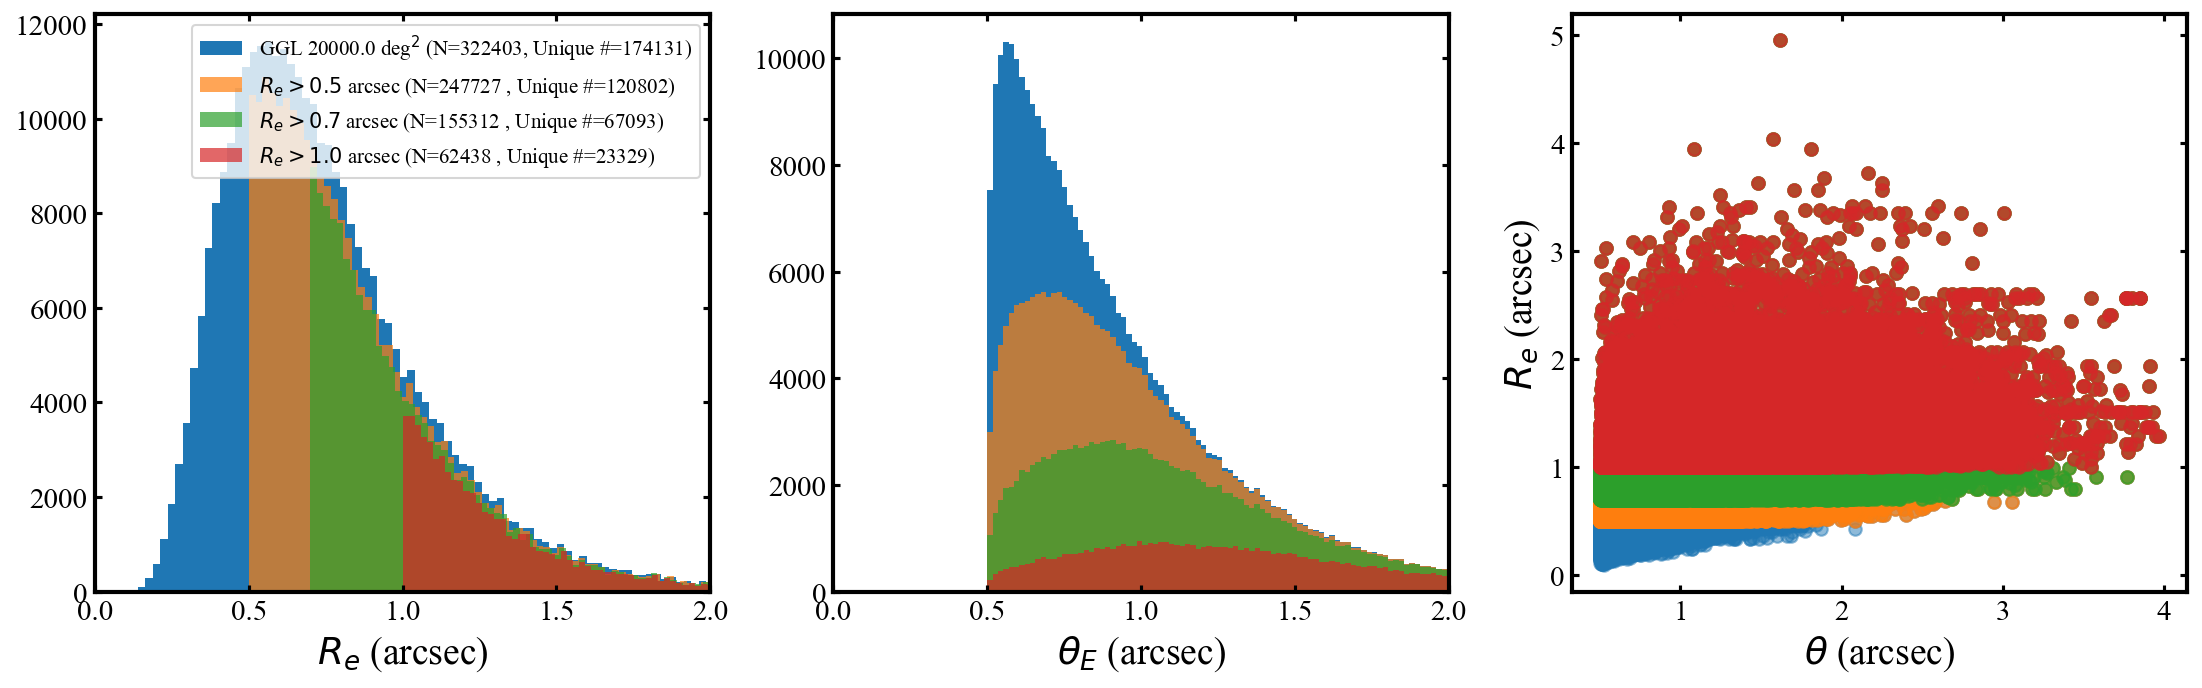

In [3]:
new_table_1 = GGL_data_table[GGL_data_table['R_e_arcsec'] > 0.5]
new_table_2 = GGL_data_table[GGL_data_table['R_e_arcsec'] > 0.7]
new_table_3 = GGL_data_table[GGL_data_table['R_e_arcsec'] > 1.0]

fig, ax = plt.subplots(1, 3, figsize=(18, 5))
ax[0].hist(GGL_data_table['R_e_arcsec'], bins=200, label=f'GGL {sky_area} deg$^2$ (N={len(GGL_data_table)}, Unique #={len(np.unique(GGL_data_table["z_D"]))})')
ax[0].hist(new_table_1['R_e_arcsec'], bins=200, alpha=0.7, label=f'$R_e > 0.5$ arcsec (N={len(new_table_1)} , Unique #={len(np.unique(new_table_1["z_D"]))})')
ax[0].hist(new_table_2['R_e_arcsec'], bins=200, alpha=0.7, label=f'$R_e > 0.7$ arcsec (N={len(new_table_2)} , Unique #={len(np.unique(new_table_2["z_D"]))})')
ax[0].hist(new_table_3['R_e_arcsec'], bins=200, alpha=0.7, label=f'$R_e > 1.0$ arcsec (N={len(new_table_3)} , Unique #={len(np.unique(new_table_3["z_D"]))})')
ax[0].set_xlim(0, 2)
ax[0].set_xlabel('$R_e$ (arcsec)')

ax[1].hist(GGL_data_table['theta_E'], bins=200, label=f'Original (N={len(GGL_data_table)})')
ax[1].hist(new_table_1['theta_E'], bins=200, alpha=0.7)
ax[1].hist(new_table_2['theta_E'], bins=200, alpha=0.7)
ax[1].hist(new_table_3['theta_E'], bins=200, alpha=0.7)
ax[1].set_xlim(0, 2)
ax[1].set_xlabel('$\\theta_E$ (arcsec)')

ax[2].scatter(GGL_data_table['theta_E'], GGL_data_table['R_e_arcsec'], label='Original', alpha=0.5)
ax[2].scatter(new_table_1['theta_E'], new_table_1['R_e_arcsec'], label='$R_e > 0.5$ arcsec', alpha=0.7)
ax[2].scatter(new_table_2['theta_E'], new_table_2['R_e_arcsec'], label='$R_e > 0.7$ arcsec', alpha=0.7)
ax[2].scatter(new_table_3['theta_E'], new_table_3['R_e_arcsec'], label='$R_e > 1.0$ arcsec', alpha=0.7)
# ax[2].set_xlim(0, 2)
ax[2].set_xlabel('$\\theta$ (arcsec)')
ax[2].set_ylabel('$R_e$ (arcsec)')

ax[0].legend()

In [4]:
########################################################
### Apply LSST magnitude depth cuts and produce pdspl_samples
########################################################

########################################################
# single exposure
# point source depths: g < 26.0, r < 25.7, i < 25.0, z < 24.3, y < 23.1
# extended source depths are 1 mag shallower: g < 25.0, r < 24.7, i < 24.0, z < 23.3, y < 22.1

# 10 year coadd
# point source depths: g < 27.4, r < 27.5, i < 26.8, z < 26.1, y < 24.9
# extended source depths are 1 mag shallower: g < 26.4, r < 26.5, i < 25.8, z < 25.1, y < 23.9

# 4MOST spec-z : r < 23.5 and z_S < 1.5

# 4MOST sigma_v_D : 50% of the spec-z sample will have sigma_v_D measurements, Collett et al 2023 [https://www.eso.org/sci/publications/messenger/archive/no.190-mar23/messenger-no190-49-52.pdf]
########################################################

# Define all LSST sample configurations in one structured dictionary
pdspl_samples = {
    # "slsim_20K_deg_sq.": {
    #     "mask": np.ones(len(GGL_data_table), dtype=bool),
    #     "title": f"SLSim Full Sample ({sky_area} deg$^2$)",
    #     "label": "SLSim Full Sample",
    #     "color": "tab:blue",
    #     "desc": "SLSim full sample; extended-source $i < 28.0$",
    #     "selc_func_latex": "$m_{i} < 28.0$"
    # },
    "lsst_single_visit": {
        "mask": (
            (GGL_data_table["mag_D_i"] < 24.0)
            & (GGL_data_table["mag_S_i_lensed"] < 24.0)
            & (GGL_data_table["R_e_arcsec"] > 0.7) # added cut on R_e_arcsec > 0.7 arcsec at LSST seeing
        ),
        "title": f"LSST Single Visit Depth ({sky_area} deg$^2$)",
        "label": "LSST SINGLE ($i < 24.0$)",
        "name": "LSST SINGLE",
        "color": "tab:orange",
        "desc": "Single exposure; extended-source $i < 24.0$",
        "selc_func_latex": "$m_{i} < 24.0, R_e > 0.7''$"
    },

    "lsst_y10": {
        "mask": (
            (GGL_data_table["mag_D_i"] < 25.8)
            & (GGL_data_table["mag_S_i_lensed"] < 25.8)
            & (GGL_data_table["R_e_arcsec"] > 0.7) # added cut on R_e_arcsec > 0.7 arcsec at LSST seeing
        ),
        "title": f"LSST 10-year Coadd Depth ({sky_area} deg$^2$)",
        "label": "LSST Y10 ($i < 25.8$)",
        "name": "LSST Y10",
        "color": "tab:green",
        "desc": "10-year coadd; extended-source $i < 25.8$",
        "selc_func_latex": "$m_{i} < 25.8, R_e > 0.7''$"
    },

    "lsst_4most_spec-z": {
        "mask": (
            (GGL_data_table["mag_S_r_lensed"] < 24.0) &
            (GGL_data_table["z_S"] < 1.5) &
            (GGL_data_table["R_e_arcsec"] > 0.7) # added cut on R_e_arcsec > 0.7 arcsec at LSST seeing
        ),
        "title": f"LSST + 4MOST spec-z Sample ({sky_area} deg$^2$)",
        "label": "LSST Y10 + 4MOST ($r < 24, z_S < 1.5$)",
        "name": "LSST Y10 + 4MOST (spec-z)",
        "color": "tab:red",
        "desc": "Spectroscopic 4MOST limit; $r < 24, z_S < 1.5$",
        "selc_func_latex": "$m_{r} < 24.0, z_S < 1.5, R_e > 0.7''$"
    },

    "lsst_4most_spec-z_sigma_v": {
        "mask": None,  # to be filled later, # half of the brightest 4MOST spec-z sample will have sigma_v measurements
        "title": f"LSST + 4MOST spec-z + "+"$\\sigma_{v, D}$"+f" Sample ({sky_area} deg$^2$)",
        "label": "LSST Y10 + 4MOST ($r < 24, z_S < 1.5$)",
        "name": "LSST Y10 + 4MOST (spec-z + $\\sigma_{v, D}$)",
        "color": "tab:purple",
        "desc": "Spectroscopic 4MOST limit; $r < 24, z_S < 1.5$",
        "selc_func_latex": "$m_{r} < 24.0, z_S < 1.5, R_e > 0.7''$"
    },
}

# Build filtered tables
for key, s in pdspl_samples.items():
    if key == 'lsst_4most_spec-z_sigma_v':
        org_mask = pdspl_samples['lsst_4most_spec-z']["mask"]
        # 50% of the brightest 4MOST spec-z sample will have sigma_v_D measurements
        brightest_indices = np.argsort(GGL_data_table['mag_D_i'])[:org_mask.sum() // 2]
        new_mask = np.zeros(len(GGL_data_table), dtype=bool)
        new_mask[brightest_indices] = True
        s["mask"] = new_mask

    s["table"] = GGL_data_table[s["mask"]]
    s["count"] = len(s["table"])

# Summary
print('-'*80)
print(f"Sky area: {sky_area} deg^2")
print('-'*80)
print(f"SLSim (i < 28, contrast_ratio > 2, mu_tot > 3, theta_E > 1\")  # lenses: {len(GGL_data_table)}")

for key, s in pdspl_samples.items():
    print(f"{s['name']:<62}# lenses: {s['count']}")

print('-'*80)

--------------------------------------------------------------------------------
Sky area: 20000.0 deg^2
--------------------------------------------------------------------------------
SLSim (i < 28, contrast_ratio > 2, mu_tot > 3, theta_E > 1")  # lenses: 322403
LSST SINGLE                                                   # lenses: 87505
LSST Y10                                                      # lenses: 153725
LSST Y10 + 4MOST (spec-z)                                     # lenses: 5113
LSST Y10 + 4MOST (spec-z + $\sigma_{v, D}$)                   # lenses: 2556
--------------------------------------------------------------------------------


In [5]:
# --- Cosmology used in SLSim and to use for forecasting ---
cosmology = "w0waCDM"  # Flat wCDM cosmology
# other options are: "FLCDM FwCDM", "w0waCDM", "oLCDM"
om_true = 0.3
w0_true = -1
wa_true = 0
h0_true = 70
kwargs_cosmo_true = {"h0": h0_true, "om": om_true, "w0": w0_true, "wa": wa_true}  # cosmological model of the forecast

cosmo_param = CosmoParam(cosmology=cosmology)
cosmo_true = cosmo_param.cosmo(kwargs_cosmo_true)

In [6]:
########################################################
### Pairing Properties and Titles
########################################################

# --- Deflector properties used for pairing ---
keys_to_pair_deflectors = [
    'z_D',
    'R_e_arcsec',
    'mag_D_i',
    'color_D_gr',
    'color_D_ri',
]

keys_to_pair_deflectors_latex = {
    'z_D': r'$z_{\mathrm{lens}}$',
    'R_e_kpc': r'$R_e$ [kpc]',
    'R_e_arcsec': r'$R_e$ [arcsec]',
    'mag_D_i': r'$m_i$',
    'color_D_gr': r'$m_g - m_r$',
    'color_D_ri': r'$m_r - m_i$',
    'sigma_v_D': r'$\sigma_{v, D}$ [km/s]',
} 

# assign pairing keys for each sample
for key, s in pdspl_samples.items():
    if key == 'lsst_4most_spec-z_sigma_v':
        pairing_keys = ['z_D', 'R_e_arcsec', 'sigma_v_D']
    else:
        pairing_keys = keys_to_pair_deflectors

    s['pairing_keys'] = pairing_keys
    s['pairing_title'] = "Paired w/ kD-Tree in " + ", ".join(
        [keys_to_pair_deflectors_latex[k] for k in pairing_keys]
    )
    s['pairing_keys_latex'] = ', '.join(
        [keys_to_pair_deflectors_latex[k] for k in pairing_keys]
    )

########################################################
## Adding errors on z_D and sigma_v_D
##########################################################

for sample_key in pdspl_samples.keys():

    # z_D errors
    if sample_key in ['lsst_single_visit', 'lsst_y10']:    
        z_D_error = 0.03 * (1 + pdspl_samples[sample_key]['table']['z_D'])  # photometric redshift error from LSST Science Book
        sample_z_Ds_with_errors = pdspl_samples[sample_key]['table']['z_D'] + np.random.normal(loc=0, scale=z_D_error)
    elif sample_key in ['lsst_4most_spec-z', 'lsst_4most_spec-z_sigma_v']:
        z_D_error = 1e-4 # spectroscopic redshift error
        sample_z_Ds_with_errors = pdspl_samples[sample_key]['table']['z_D'] + np.random.normal(loc=0, scale=z_D_error)  
    else:
        sample_z_Ds_with_errors = pdspl_samples[sample_key]['table']['z_D']
    
    # sigma_v_D errors
    if sample_key == 'lsst_4most_spec-z_sigma_v':
        sigma_v_error = 10.0  # fixed 10 km/s error on sigma_v_D [https://ui.adsabs.harvard.edu/abs/2024MNRAS.527.5311L/abstract]
        sample_sigma_v_Ds_with_errors = pdspl_samples[sample_key]['table']['sigma_v_D'] + np.random.normal(loc=0, scale=sigma_v_error)
    else:
        sample_sigma_v_Ds_with_errors = pdspl_samples[sample_key]['table']['sigma_v_D']

    # R_e errors => 5-10% error on R_e
    R_e_error = 0.05 * (pdspl_samples[sample_key]['table']['R_e_arcsec'])
    sample_R_e_arcsec_with_errors = pdspl_samples[sample_key]['table']['R_e_arcsec'] + np.random.normal(loc=0, scale=R_e_error)

    # add these errors to a new table
    pdspl_samples[sample_key]['table_with_errors'] = pdspl_samples[sample_key]['table'].copy()
    pdspl_samples[sample_key]['table_with_errors']['z_D'] = sample_z_Ds_with_errors
    pdspl_samples[sample_key]['table_with_errors']['sigma_v_D'] = sample_sigma_v_Ds_with_errors
    pdspl_samples[sample_key]['table_with_errors']['R_e_arcsec'] = sample_R_e_arcsec_with_errors
########################################################

########################################################
## define dissimilarity estimator parameters for each sample
##########################################################
# --- Define which parameters to include in the dissimilarity estimator ---
keys_to_use_for_dissimilarity = [
    "rel_diff_R_e_arcsec",
    "rel_diff_z_D",
    "rel_diff_mag_D_i",
    "rel_diff_color_D_gr",
    "rel_diff_color_D_ri"
]

# --- (optional) Define pretty LaTeX labels for each key ---
key_latex_map = {
    "rel_diff_R_e_arcsec": r"\frac{\Delta R_e}{R_e}",
    "rel_diff_z_D": r"\frac{\Delta z_D}{z_D}",
    "rel_diff_mag_D_i": r"\frac{\Delta m_i}{m_i}",
    "rel_diff_color_D_gr": r"\frac{\Delta c_{gr}}{c_{gr}}",
    "rel_diff_color_D_ri": r"\frac{\Delta c_{ri}}{c_{ri}}"
}

# assign dissimilarity keys for each sample
for key, s in pdspl_samples.items():
    if key == 'lsst_4most_spec-z_sigma_v':
        dissimilarity_keys = [
            "rel_diff_z_D",
            "rel_diff_R_e_arcsec",
            "rel_diff_sigma_v_D"
        ]
    else:
        dissimilarity_keys = keys_to_use_for_dissimilarity

    s['dissimilarity_keys'] = dissimilarity_keys
############################################################


########################################################
## define pairs selection function to select near-identical deflectors within 1 sigma
##########################################################
def select_near_identical_deflectors(sample, pairs_table_with_errors, sigma = 0.02):

    diffs = np.array([pairs_table_with_errors[k] for k in sample['dissimilarity_keys']])
    estimator = np.sqrt(np.mean(diffs**2, axis=0))

    idxs = np.where(estimator < sigma)[0]

    return pairs_table_with_errors[idxs], idxs
########################################################

In [7]:
########################################################
###  Get pairs table for each LSST sample
########################################################

for sample_key, s in pdspl_samples.items():
    table = s["table"]

    if len(table) < 2:
        print(f"⚠️ Skipping {sample_key}: too few lenses ({len(table)})")
        continue

    # print(f"\nBuilding full pairs table for {s['name']} ...")

    pairing_keys = s['pairing_keys']
    pairing_title = s['pairing_title']

    # Normalized feature space, use table with errors for pairing
    points = np.stack(
        [normalize_data(s['table_with_errors'][pk], type='zscore') for pk in pairing_keys],
        axis=1
    )

    # Pair with KD-tree
    indices, _ = kdtree_matching_n_dim(points=points, n_neighbors=2, unique_pairs=True)

    # Build pairs table from kD-tree indices
    pairs_table = get_pairs_table_PDSPL(table, pair_indices=indices, cosmo=cosmo_true)
    pairs_table_with_errors = get_pairs_table_PDSPL(s['table_with_errors'], pair_indices=indices, cosmo=cosmo_true)

    # print(f"len of pairs table before selecting near-identical deflectors: {len(pairs_table)}")

    # Select near-identical deflectors, in reality we will only have the table with errors to select pairs
    # pairs_table_with_errors, idxs = select_near_identical_deflectors(
    #                                     sample= s,
    #                                     pairs_table_with_errors= pairs_table_with_errors,
    #                                     sigma=0.01)
    # pairs_table = pairs_table[idxs]

    # print(f"len of pairs table after selecting near-identical deflectors: {len(pairs_table)}")

    # Compute summary stats
    num_lenses = len(table)
    num_pairs = len(pairs_table)
    beta_ratio = pairs_table["beta_E_pseudo"] / pairs_table["beta_E_DSPL"]
    scatter_in_beta_E = np.std(1 - beta_ratio)
    mean_beta_ratio = np.mean(beta_ratio)
    median_beta_ratio = np.median(beta_ratio)

    # Store results inside the sample dict
    s["pairs_analysis"] = {
        "pairs_table": pairs_table,
        "pairs_table_with_errors": pairs_table_with_errors,
        "num_lenses": num_lenses,
        "num_pairs": num_pairs,
        "scatter_in_beta_E": scatter_in_beta_E,
        "mean_beta_ratio": mean_beta_ratio,
        "median_beta_ratio": median_beta_ratio,
        "pairing_keys": pairing_keys,
        "pairing_title": pairing_title,
        "pairing_points": points,
    }

    print(f"✅ {s['name']}: {num_pairs} pairs, scatter = {scatter_in_beta_E:.4f}")

Processing pairs: 100%|██████████| 63816/63816 [00:11<00:00, 5530.80it/s]


✅ LSST SINGLE: 63816 pairs, scatter = 0.1739


Processing pairs: 100%|██████████| 111980/111980 [00:20<00:00, 5408.64it/s]


✅ LSST Y10: 111980 pairs, scatter = 0.1872


Processing pairs: 100%|██████████| 3677/3677 [00:00<00:00, 5743.60it/s]


✅ LSST Y10 + 4MOST (spec-z): 3677 pairs, scatter = 0.1145


Processing pairs: 100%|██████████| 1785/1785 [00:00<00:00, 5701.89it/s]

✅ LSST Y10 + 4MOST (spec-z + $\sigma_{v, D}$): 1785 pairs, scatter = 0.0459


In [10]:
########################################################
###  Scaling relation analysis for each LSST sample
########################################################

# --- Parameters ---
sky_areas = np.linspace(1000, 20000, 40)  # deg^2
fraction_of_max = sky_areas / max(sky_areas)

# --- Loop over all LSST samples ---
for sample_key, s in pdspl_samples.items():
    print(f"\nAnalyzing scaling relations for {s['label']} ...")

    table_full = s["table"]
    table_full_with_errors = s["table_with_errors"]

    # Skip empty tables
    if len(table_full_with_errors) < 2:
        print(f"⚠️  Skipping {sample_key} (too few lenses)")
        continue

    # Generate tables for different sky areas
    GGL_tables_with_errors_at_different_areas = {}
    GGL_tables_at_different_sky_areas = {}
    for area in sky_areas:
        num_rows = int(len(table_full_with_errors) * (area / max(sky_areas)))
        if num_rows < 2:
            continue
        indexes_ = np.random.choice(len(table_full_with_errors), num_rows, replace=False)
        subset_errors = table_full_with_errors[indexes_]
        subset = table_full[indexes_]
        GGL_tables_at_different_sky_areas[area] = subset
        GGL_tables_with_errors_at_different_areas[area] = subset_errors

    # Arrays to store results
    num_pairs_at_different_areas = []
    scatter_in_beta_E_at_different_areas = []
    num_lenses_at_different_sky_areas = []

    pairing_title = s['pairing_title']
    pairing_keys = s['pairing_keys']

    # --- Main scaling loop ---
    for area in sky_areas:
        if area not in GGL_tables_with_errors_at_different_areas:
            continue
        table = GGL_tables_at_different_sky_areas[area]
        table_errors = GGL_tables_with_errors_at_different_areas[area]

        # Normalize and pair
        points = np.stack(
            [normalize_data(table_errors[pk], type='zscore') for pk in pairing_keys],
            axis=1
        )
        indices, _ = kdtree_matching_n_dim(points=points, n_neighbors=2, unique_pairs=True)
        pairs_table = get_pairs_table_PDSPL(table, pair_indices=indices, cosmo=cosmo_true, progress_bar=False)

        num_pairs = len(pairs_table)
        num_lenses = len(table)
        scatter_in_beta_E = np.std(1 - pairs_table["beta_E_pseudo"] / pairs_table["beta_E_DSPL"])

        num_pairs_at_different_areas.append(num_pairs)
        scatter_in_beta_E_at_different_areas.append(scatter_in_beta_E)
        num_lenses_at_different_sky_areas.append(num_lenses)

    # --- Store results back into the sample dictionary ---
    s["scaling_results"] = {
        "sky_areas": sky_areas,
        "num_lenses": np.array(num_lenses_at_different_sky_areas),
        "num_pairs": np.array(num_pairs_at_different_areas),
        "scatter_in_beta_E": np.array(scatter_in_beta_E_at_different_areas),
        "pairing_keys": pairing_keys,
        "pairing_title": pairing_title,
    }

    print(f"✅ Finished {s['label']} | {len(s['scaling_results']['num_pairs'])} area bins processed.")
########################################################


Analyzing scaling relations for LSST SINGLE ($i < 24.0$) ...
✅ Finished LSST SINGLE ($i < 24.0$) | 40 area bins processed.

Analyzing scaling relations for LSST Y10 ($i < 25.8$) ...
✅ Finished LSST Y10 ($i < 25.8$) | 40 area bins processed.

Analyzing scaling relations for LSST Y10 + 4MOST ($r < 24, z_S < 1.5$) ...
✅ Finished LSST Y10 + 4MOST ($r < 24, z_S < 1.5$) | 40 area bins processed.

Analyzing scaling relations for LSST Y10 + 4MOST ($r < 24, z_S < 1.5$) ...
✅ Finished LSST Y10 + 4MOST ($r < 24, z_S < 1.5$) | 40 area bins processed.


In [8]:
########################################################
## Latex Table 1: Summary of all samples
## Columns: Sample, # Lenses, Selection Criteria
########################################################

print("Latex Table 1: Summary of all samples\n")

print(r"\begin{tabular}{l c c}")
print(r"\hline")
print(r"\textbf{Sample} & \textbf{\# Lenses} & \textbf{Selection Criteria}\\")
print(r"\hline")

# Main SLSim entry (spanning two rows)
print(
    f"\\multirow{{2}}{{*}}{{SLSim 20000 deg$^2$}} & "
    f"\\multirow{{2}}{{*}}{{{len(GGL_data_table)}}} & "
    + "$m_{i} < 28.0$, $\\mu_{\\rm tot} > 3$, $1'' < \\Delta \\theta < 8''$ \\\\"
)
print(r" & & contrast ratio $> 2$, $m_{i}^{\rm 2^{\rm nd} \ brightest} < 26$\\\\")

# Other samples
for key, s in pdspl_samples.items():
    print(f"{s['name']} & {s['count']} & {s['selc_func_latex']} \\\\")

print(r"\hline")
print(r"\end{tabular}")
########################################################


########################################################
## Latex Table 2: Pairing parameters per sample
## Columns: Sample, Pairing Parameters
########################################################

print("\nLatex Table 2: Pairing Parameters\n")

print(r"\begin{tabular}{l c}")
print(r"\hline")
print(r"\textbf{Sample} & \textbf{Pairing Parameters}\\")
print(r"\hline")

# Loop through paired samples
for key, s in pdspl_samples.items():
    print(f"{s['name']} & {s['pairing_keys_latex']} \\\\")

print(r"\hline")
print(r"\end{tabular}")
########################################################

Latex Table 1: Summary of all samples

\begin{tabular}{l c c}
\hline
\textbf{Sample} & \textbf{\# Lenses} & \textbf{Selection Criteria}\\
\hline
\multirow{2}{*}{SLSim 20000 deg$^2$} & \multirow{2}{*}{322403} & $m_{i} < 28.0$, $\mu_{\rm tot} > 3$, $1'' < \Delta \theta < 8''$ \\
 & & contrast ratio $> 2$, $m_{i}^{\rm 2^{\rm nd} \ brightest} < 26$\\\\
LSST SINGLE & 87505 & $m_{i} < 24.0, R_e > 0.7''$ \\
LSST Y10 & 153725 & $m_{i} < 25.8, R_e > 0.7''$ \\
LSST Y10 + 4MOST (spec-z) & 5113 & $m_{r} < 24.0, z_S < 1.5, R_e > 0.7''$ \\
LSST Y10 + 4MOST (spec-z + $\sigma_{v, D}$) & 2556 & $m_{r} < 24.0, z_S < 1.5, R_e > 0.7''$ \\
\hline
\end{tabular}

Latex Table 2: Pairing Parameters

\begin{tabular}{l c}
\hline
\textbf{Sample} & \textbf{Pairing Parameters}\\
\hline
LSST SINGLE & $z_{\mathrm{lens}}$, $R_e$ [arcsec], $m_i$, $m_g - m_r$, $m_r - m_i$ \\
LSST Y10 & $z_{\mathrm{lens}}$, $R_e$ [arcsec], $m_i$, $m_g - m_r$, $m_r - m_i$ \\
LSST Y10 + 4MOST (spec-z) & $z_{\mathrm{lens}}$, $R_e$ [arcsec],

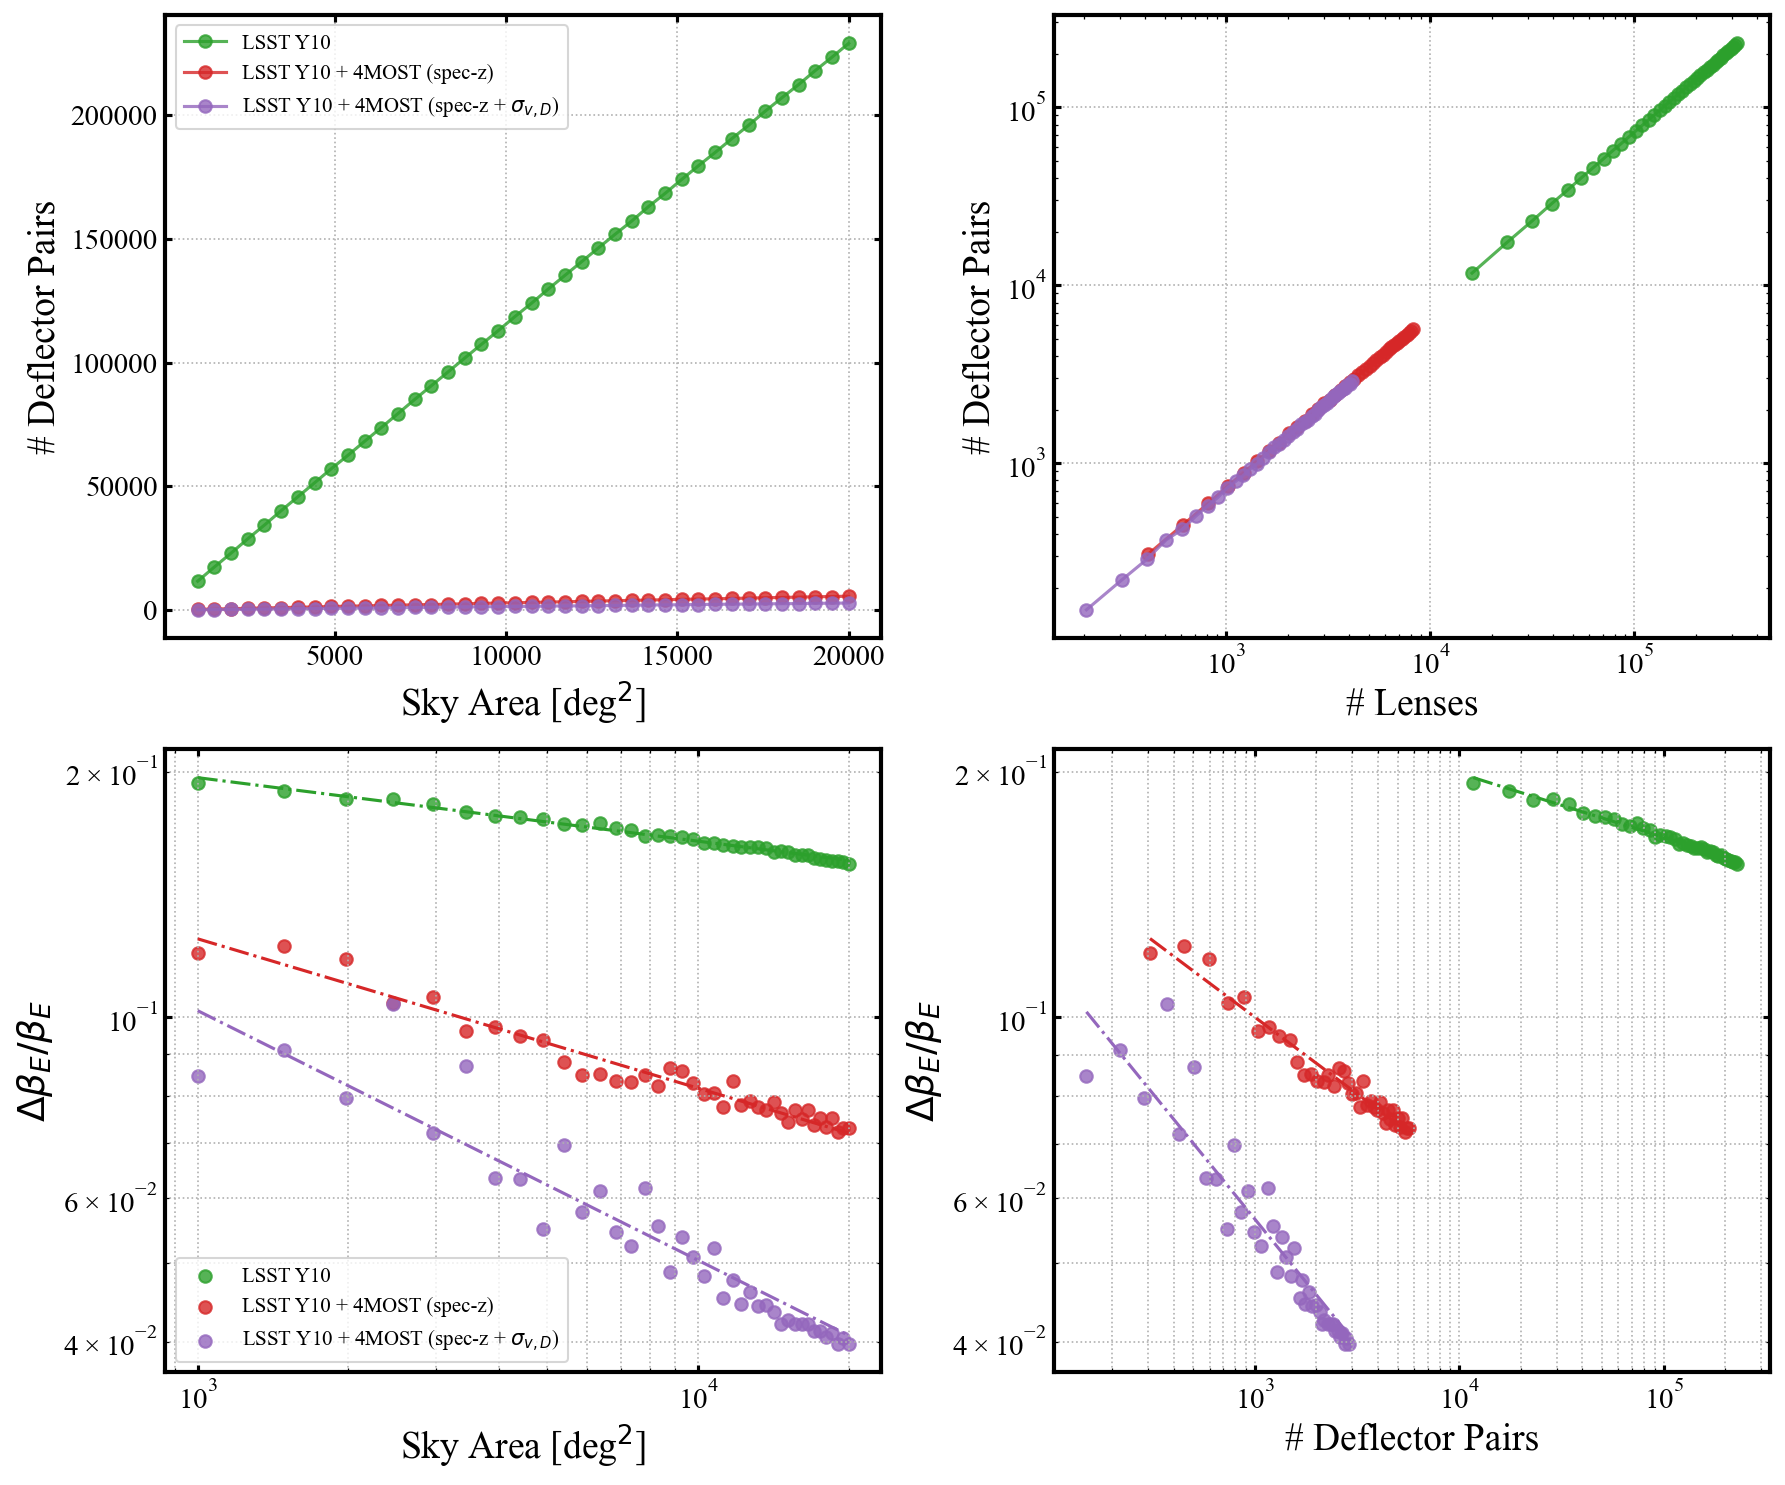

In [ ]:
########################################################
###  Multi-panel plots for scaling relations
########################################################

keys_to_plot = ["lsst_y10", 
                "lsst_4most_spec-z", 
                "lsst_4most_spec-z_sigma_v"]

def power_law(x, a, b):
    return a * x**b

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
(ax1, ax2), (ax3, ax4) = axes
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# --- Plot 1: # of deflector pairs vs sky area ---
for key in keys_to_plot:
    s = pdspl_samples[key]
    if "scaling_results" not in s: 
        continue
    sr = s["scaling_results"]
    ax1.plot(sr["sky_areas"], sr["num_pairs"], 
             label=s["name"], color=s["color"], marker='o', alpha=0.8)
ax1.set_xlabel("Sky Area [deg$^2$]")
ax1.set_ylabel("# Deflector Pairs")
# ax1.set_title("# of Deflector Pairs vs Sky Area")
ax1.legend()
ax1.grid(True, ls=':')

# --- Plot 2: # of deflector pairs vs number of lenses ---
for key in keys_to_plot:
    s = pdspl_samples[key]
    if "scaling_results" not in s:
        continue
    sr = s["scaling_results"]
    ax2.plot(sr["num_lenses"], sr["num_pairs"], 
             label=s["name"], color=s["color"], marker='o', alpha=0.8)
ax2.set_xlabel("# Lenses")
ax2.set_ylabel("# Deflector Pairs")
ax2.set_xscale("log")
ax2.set_yscale("log")
# ax2.set_title("# of Deflector Pairs vs # of Lenses")
ax2.grid(True, ls=':')

# --- Plot 3: scatter_in_beta_E vs sky area ---
for key in keys_to_plot:
    s = pdspl_samples[key]
    if "scaling_results" not in s:
        continue
    sr = s["scaling_results"]
    x = sr["sky_areas"]
    y = sr["scatter_in_beta_E"]

    ax3.scatter(x, y, color=s["color"], label=s["name"], alpha=0.8)
    
    # Fit a power law
    try:
        popt, _ = curve_fit(power_law, x, y, maxfev=10000)
        x_fit = np.linspace(min(x), max(x), 200)
        y_fit = power_law(x_fit, *popt)
        ax3.plot(x_fit, y_fit, ls='-.', color=s["color"])
    except:
        print(f"⚠️ Power law fit failed for {key}")

ax3.set_xlabel("Sky Area [deg$^2$]")
ax3.set_ylabel("${\\Delta \\beta_E}/{\\beta_E}$")
# ax3.set_title("Scatter in $\\beta_E$ vs Sky Area")
ax3.set_xscale("log")
ax3.set_yscale("log")
ax3.grid(True, which='both', ls=':')
ax3.legend()

# --- Plot 4: scatter_in_beta_E vs num of deflector pairs ---
for key in keys_to_plot:
    s = pdspl_samples[key]
    if "scaling_results" not in s:
        continue
    sr = s["scaling_results"]
    x = sr["num_pairs"]
    y = sr["scatter_in_beta_E"]

    ax4.scatter(x, y, color=s["color"], label=s["name"], alpha=0.8)
    
    # Fit a power law
    try:
        popt, _ = curve_fit(power_law, x, y, maxfev=10000)
        x_fit = np.linspace(min(x), max(x), 200)
        y_fit = power_law(x_fit, *popt)
        ax4.plot(x_fit, y_fit, ls='-.', color=s["color"])
    except:
        print(f"⚠️ Power law fit failed for {key}")
    
    # store fitting parameters
    pdspl_samples[key]['scaling_results']['power_law_fit_params_beta_E_vs_num_pairs'] = {
        'a': popt[0],
        'b': popt[1],
    }

ax4.set_xlabel("# Deflector Pairs")
ax4.set_ylabel("${\\Delta \\beta_E}/{\\beta_E}$")
# ax4.set_title("Scatter in $\\beta_E$ vs # of Deflector Pairs")
ax4.set_xscale("log")
ax4.set_yscale("log")
ax4.grid(True, which='both', ls=':')

fig.tight_layout()

# save the figure
# plt.savefig(f"../figures/slsim_all_samples_pairing_statistics.pdf", dpi=300)
# plt.savefig(f"../figures/slsim_all_samples_pairing_statistics.png", dpi=300)

In [8]:
print("\nLatex Table 3: Summary of Pairing Analysis Results\n")

keys_to_plot = ["lsst_y10", 
                "lsst_4most_spec-z", 
                "lsst_4most_spec-z_sigma_v"]

print(r"\begin{tabular}{l | c c c | c c}")
print(r"\hline")
print(r"\multirow{2}{*}{\textbf{Sample}} & \multicolumn{3}{c|}{\textbf{Pairing at 20K deg$^2$}} & \multicolumn{2}{c}{\textbf{PL Fit}} \\")
print(r" & \textbf{\# Lenses} & \textbf{\# Pairs} & \textbf{${\Delta\beta_{\rm E}}/{\beta_{\rm E}}$} & \textbf{a} & \textbf{b} \\")
print(r"\hline")

# Loop through paired samples
for key in keys_to_plot:
    s = pdspl_samples[key]
    if "pairs_analysis" not in s:
        continue
    pa = s["pairs_analysis"]
    fit_params = s['scaling_results']['power_law_fit_params_beta_E_vs_num_pairs']
    print(
        f"{s['name']} & "
        f"{pa['num_lenses']} & "
        f"{pa['num_pairs']} & "
        f"{pa['scatter_in_beta_E']:.4f} & "
        f"{fit_params['a']:.2f} & "
        f"{fit_params['b']:.2f} \\\\"
    )

print(r"\hline")
print(r"\end{tabular}")



Latex Table 3: Summary of Pairing Analysis Results

\begin{tabular}{l | c c c | c c}
\hline
\multirow{2}{*}{\textbf{Sample}} & \multicolumn{3}{c|}{\textbf{Pairing at 20K deg$^2$}} & \multicolumn{2}{c}{\textbf{PL Fit}} \\
 & \textbf{\# Lenses} & \textbf{\# Pairs} & \textbf{${\Delta\beta_{\rm E}}/{\beta_{\rm E}}$} & \textbf{a} & \textbf{b} \\
\hline


KeyError: 'scaling_results'

Plotting for LSST Y10 ($i < 25.8$) with 111980 pairs
Plotting for LSST Y10 + 4MOST ($r < 24, z_S < 1.5$) with 3677 pairs
Plotting for LSST Y10 + 4MOST ($r < 24, z_S < 1.5$) with 1785 pairs


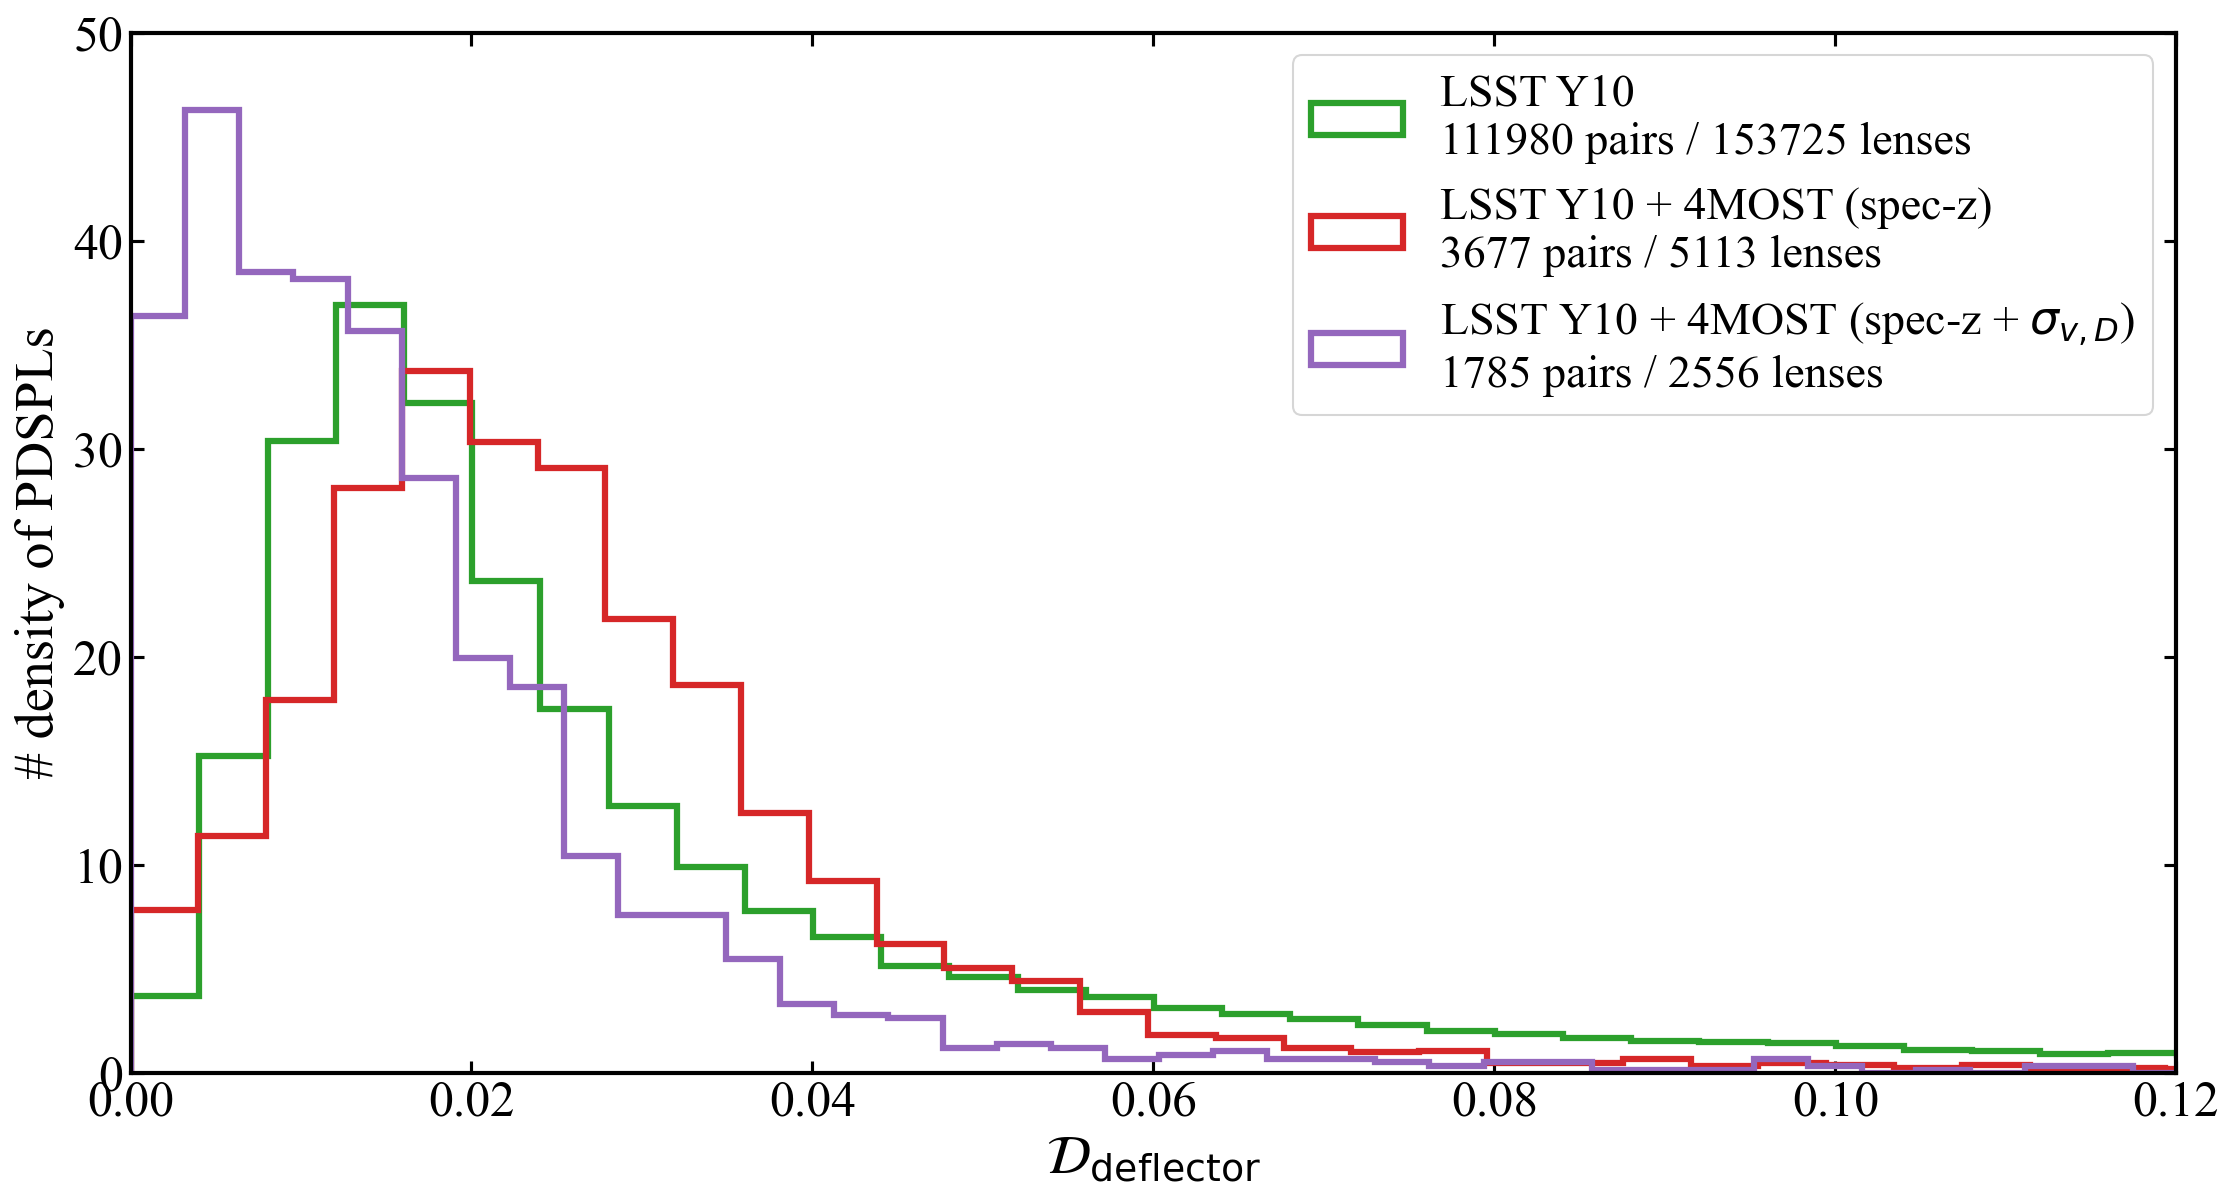

In [9]:
########################################################
###  Deflector Dissimilarity Parameter Plot
########################################################
# Build the LaTeX string dynamically
# latex_terms = " + ".join([f"\\left({key_latex_map[k]}\\right)^2" for k in keys_to_use_for_dissimilarity])
# latex_equation = rf"$\mathcal{{D}}_{{\rm deflector}} = \sqrt{{\frac{{1}}{{{len(keys_to_use_for_dissimilarity)}}}\left[{latex_terms}\right]}}$"

# --- Plot setup ---
fig, ax = plt.subplots(figsize=(15, 9))
samples_to_plot = ["lsst_y10", 
                   "lsst_4most_spec-z", 
                   "lsst_4most_spec-z_sigma_v"]

for key in samples_to_plot:
    s = pdspl_samples[key]
    if "pairs_analysis" not in s:
        print(f"⚠️ Skipping {s['label']} (no pairs_analysis found)")
        continue
    
    pairs_table = s["pairs_analysis"]["pairs_table"]
    pairs_table_with_errors = s["pairs_analysis"]["pairs_table_with_errors"]

    if len(pairs_table_with_errors) == 0:
        print(f"⚠️ Skipping {s['label']} (no pairs found)")
        continue

    print(f"Plotting for {s['label']} with {len(pairs_table_with_errors)} pairs")

    # --- Compute dissimilarity dynamically ---
    diffs = np.array([pairs_table_with_errors[k] for k in s['dissimilarity_keys']])
    estimator = np.sqrt(np.mean(diffs**2, axis=0))

    # Limit max for visualization
    estimator = estimator[estimator < 0.2]

    ax.hist(
        estimator,
        bins=50,
        color=s["color"],
        density=True,
        label=f"{s['name']}\n{len(pairs_table_with_errors)} pairs / {len(s['table'])} lenses",
        histtype='step',
        linewidth=3,
    )

# --- Axis formatting ---
ax.set_xlabel(r'$\mathcal{D}_{\rm deflector}$', fontsize=26)
ax.set_ylabel(r'# density of PDSPLs', fontsize=26)
ax.tick_params(axis='both', which='major', labelsize=24, length=6, width=1.5)
ax.set_xlim(0, 0.12)
ax.set_ylim(0, 50)

# --- Dynamic title with variable count ---
# ax.set_title(
#     f"PDSPL Pairs: Deflector Dissimilarity Parameter ({len(keys_to_use_for_dissimilarity)} terms)",
#     fontsize=22, pad=14
# )
ax.legend(fontsize=22, frameon=True, loc='upper right')

# --- Equation above plot ---
# fig.text(0.5, 0.90, latex_equation, ha='center', va='bottom', fontsize=24)

fig.tight_layout(rect=[0, 0, 1, 0.9])

# save the figure
# fig.savefig(f"../figures/slsim_all_samples_deflector_dissimilarity_parameter.pdf", dpi=300)
# fig.savefig(f"../figures/slsim_deflector_dissimilarity_parameter.png", dpi=300)


Plotting for LSST SINGLE ($i < 24.0$) with 63816 pairs
Plotting for LSST Y10 ($i < 25.8$) with 111980 pairs
Plotting for LSST Y10 + 4MOST ($r < 24, z_S < 1.5$) with 3677 pairs
Plotting for LSST Y10 + 4MOST ($r < 24, z_S < 1.5$) with 1785 pairs


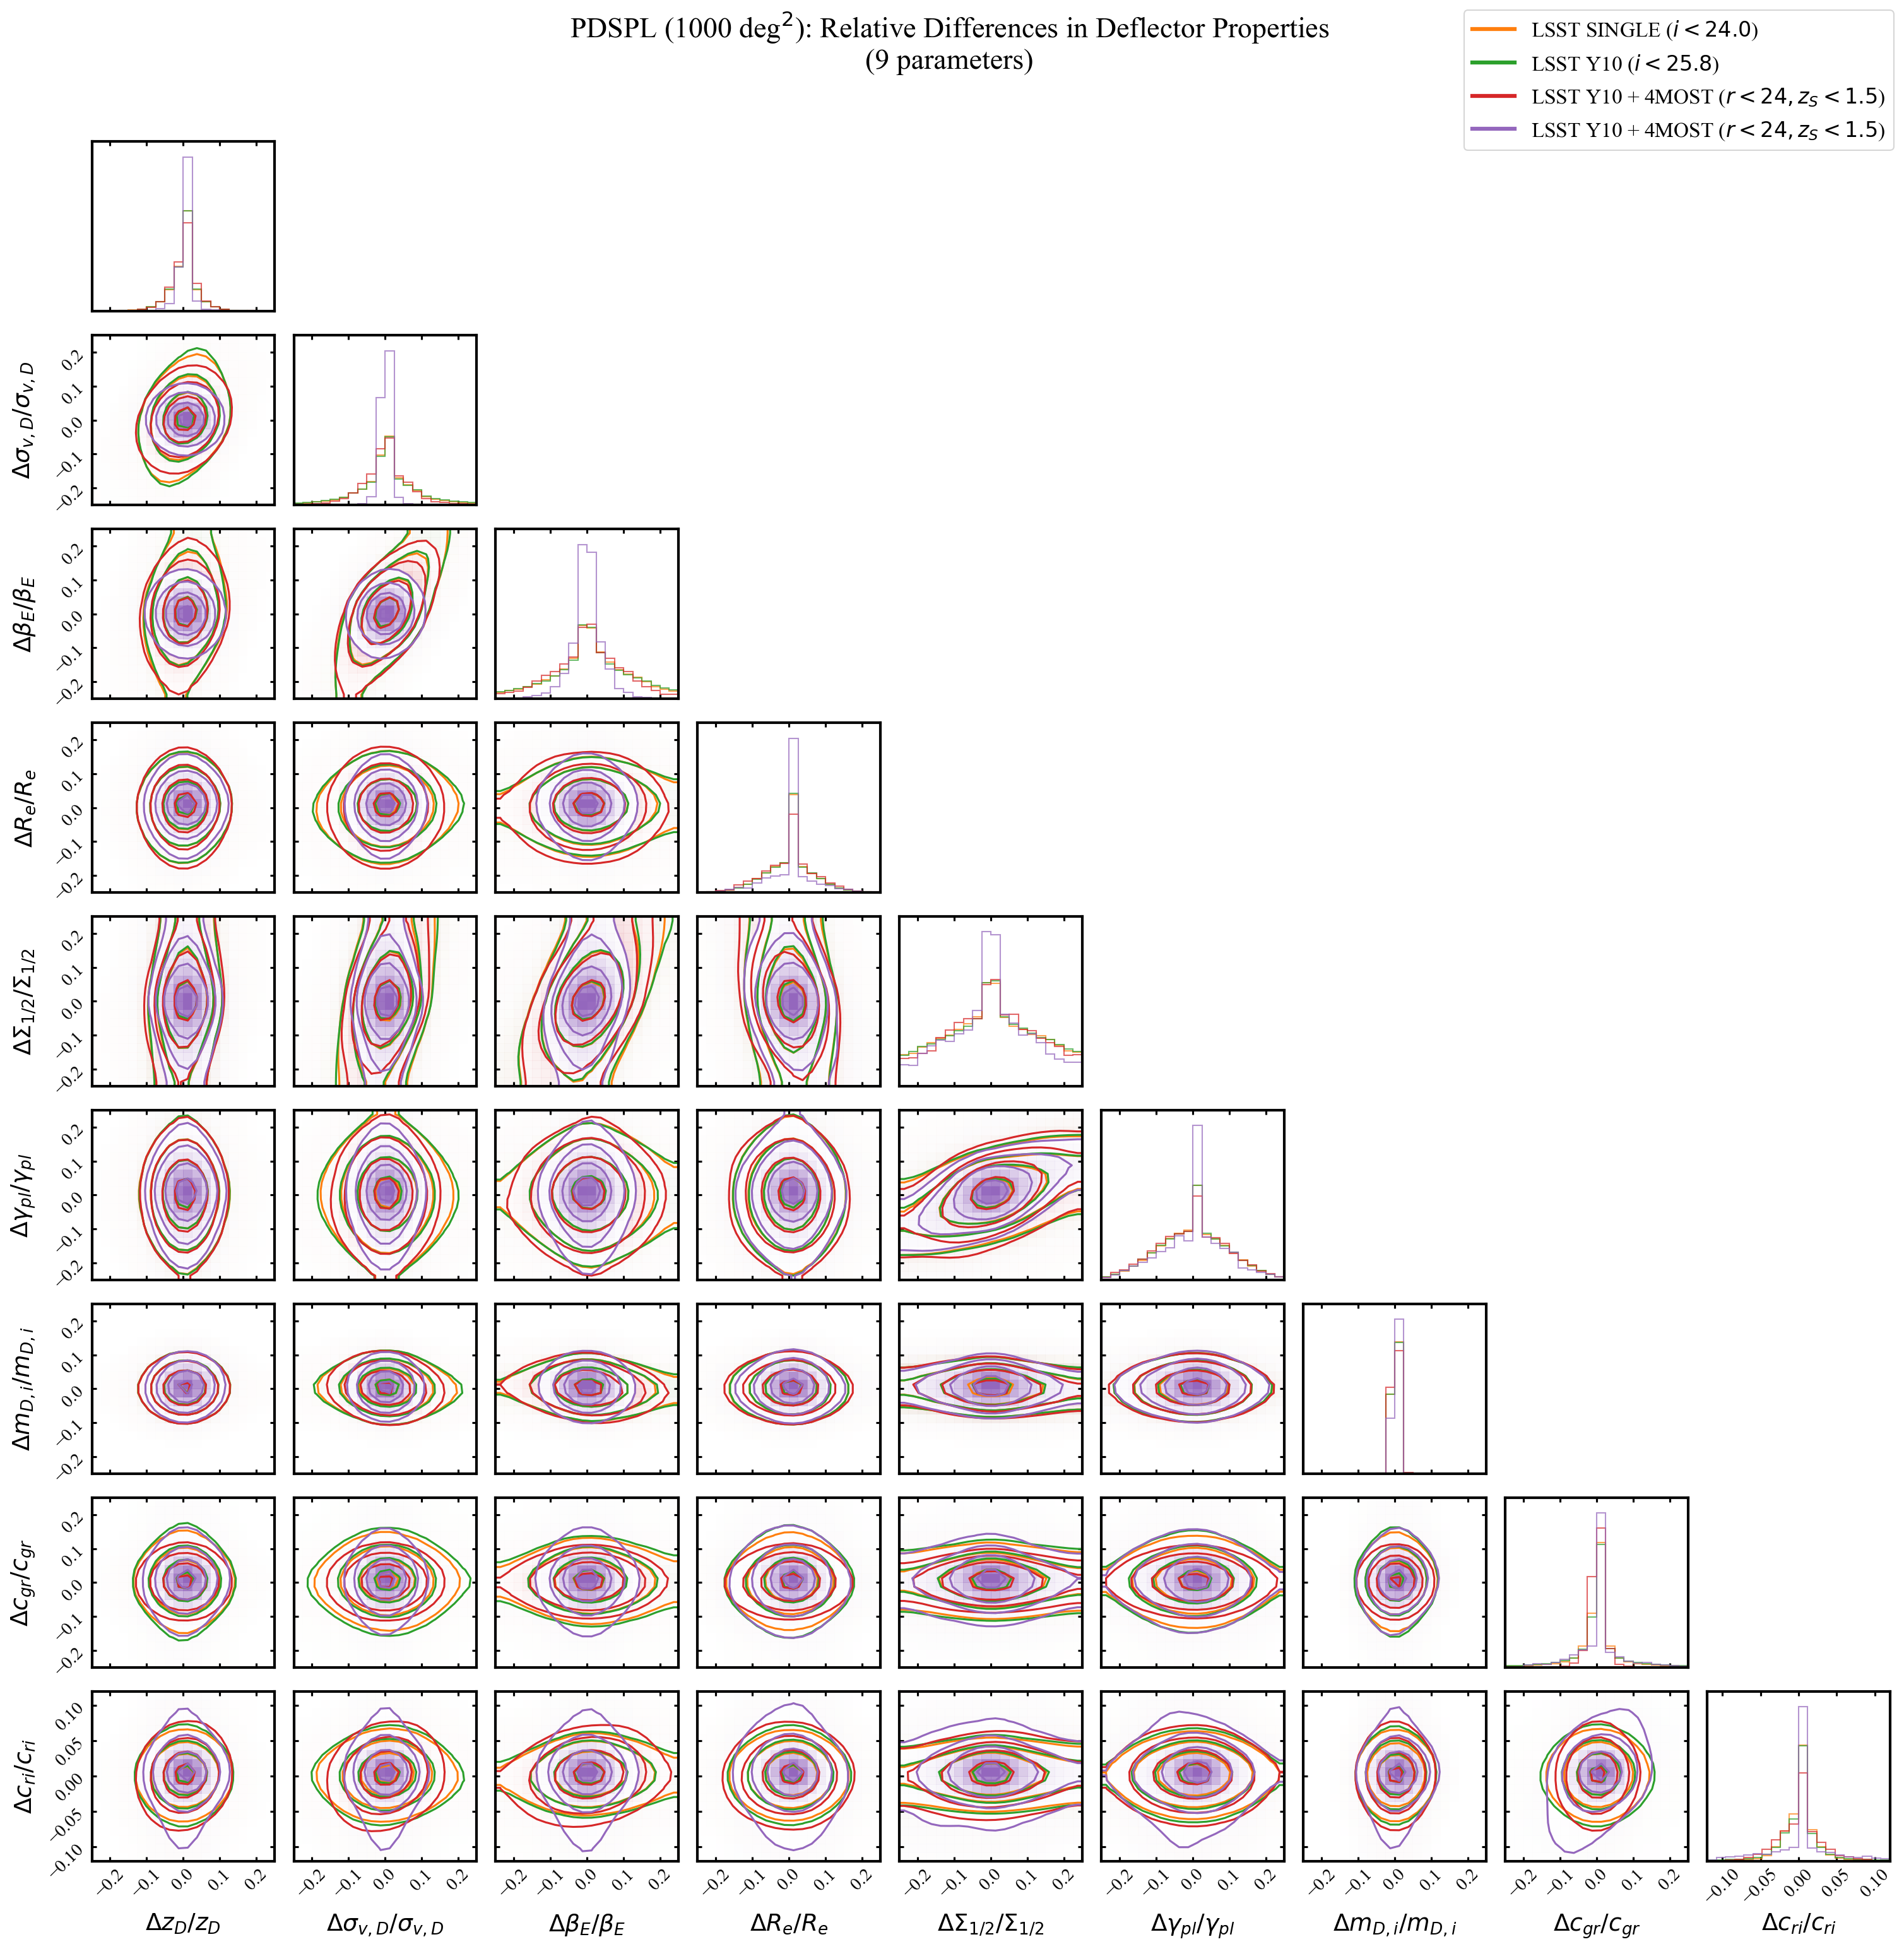

In [10]:
########################################################
###  Corner Plot for Deflector Pair Differences
########################################################

# --- Define which relative-difference parameters to include ---
keys_to_use_for_corner = [
    "rel_diff_z_D",
    "rel_diff_sigma_v_D",
    "rel_diff_beta_E",
    "rel_diff_R_e_arcsec",
    "rel_diff_Sigma_half",
    "rel_diff_gamma_pl",
    "rel_diff_mag_D_i",
    "rel_diff_color_D_gr",
    "rel_diff_color_D_ri"
]

# --- Define LaTeX labels dynamically for corner axes ---
key_latex_map = {
    "rel_diff_z_D":        r"$\Delta z_{D} / z_{D}$",
    "rel_diff_sigma_v_D":  r"$\Delta \sigma_{v,D} / \sigma_{v,D}$",
    "rel_diff_beta_E":     r"$\Delta \beta_{E} / \beta_{E}$",
    "rel_diff_R_e_arcsec": r"$\Delta R_{e} / R_{e}$",
    "rel_diff_Sigma_half": r"$\Delta \Sigma_{1/2} / \Sigma_{1/2}$",
    "rel_diff_gamma_pl":   r"$\Delta \gamma_{pl} / \gamma_{pl}$",
    "rel_diff_mag_D_i":    r"$\Delta m_{D,i} / m_{D,i}$",
    "rel_diff_color_D_gr": r"${\Delta c_{gr}} / {c_{gr}}$",
    "rel_diff_color_D_ri": r"${\Delta c_{ri}} / {c_{ri}}$"
}

corner_labels = [key_latex_map[k] for k in keys_to_use_for_corner]

# --- Which samples to plot ---
samples_to_plot = ["lsst_single_visit", "lsst_y10", 
                   "lsst_4most_spec-z", 
                   "lsst_4most_spec-z_sigma_v"]

# --- Plotting ---
figure = None  # will hold combined corner plot

for key in samples_to_plot:
    s = pdspl_samples[key]
    if "pairs_analysis" not in s:
        print(f"⚠️ Skipping {s['label']} (no pairs_analysis found)")
        continue

    pairs_table = s["pairs_analysis"]["pairs_table"]

    if len(pairs_table) == 0:
        print(f"⚠️ Skipping {s['label']} (no pairs found)")
        continue

    print(f"Plotting for {s['label']} with {len(pairs_table)} pairs")

    # --- Build corner data array dynamically ---
    corner_data = np.vstack([pairs_table[k] for k in keys_to_use_for_corner]).T

    figure = corner.corner(
        corner_data,
        labels=corner_labels,
        color=s["color"],
        fig=figure,                      # overlay all samples on same figure
        smooth=2.0,
        hist_kwargs={"density": True, "alpha": 0.7},
        plot_density=True,
        plot_datapoints=False,
        show_titles=False,
        label_kwargs={"fontsize": 18},
        range=[(-0.25, 0.25)] * (len(keys_to_use_for_corner) - 1) + [(-0.12, 0.12)],
    )

# --- Add legend manually ---
handles = [
    plt.Line2D([], [], color=pdspl_samples[k]["color"], lw=3, label=pdspl_samples[k]["label"])
    for k in samples_to_plot
]
figure.legend(handles=handles, loc="upper right", fontsize=16)

# --- Title & layout ---
figure.suptitle(
    f"PDSPL (1000 deg$^2$): Relative Differences in Deflector Properties\n"
    f"({len(keys_to_use_for_corner)} parameters)",
    fontsize=22,
    y=1.02
)
figure.tight_layout()
plt.show()

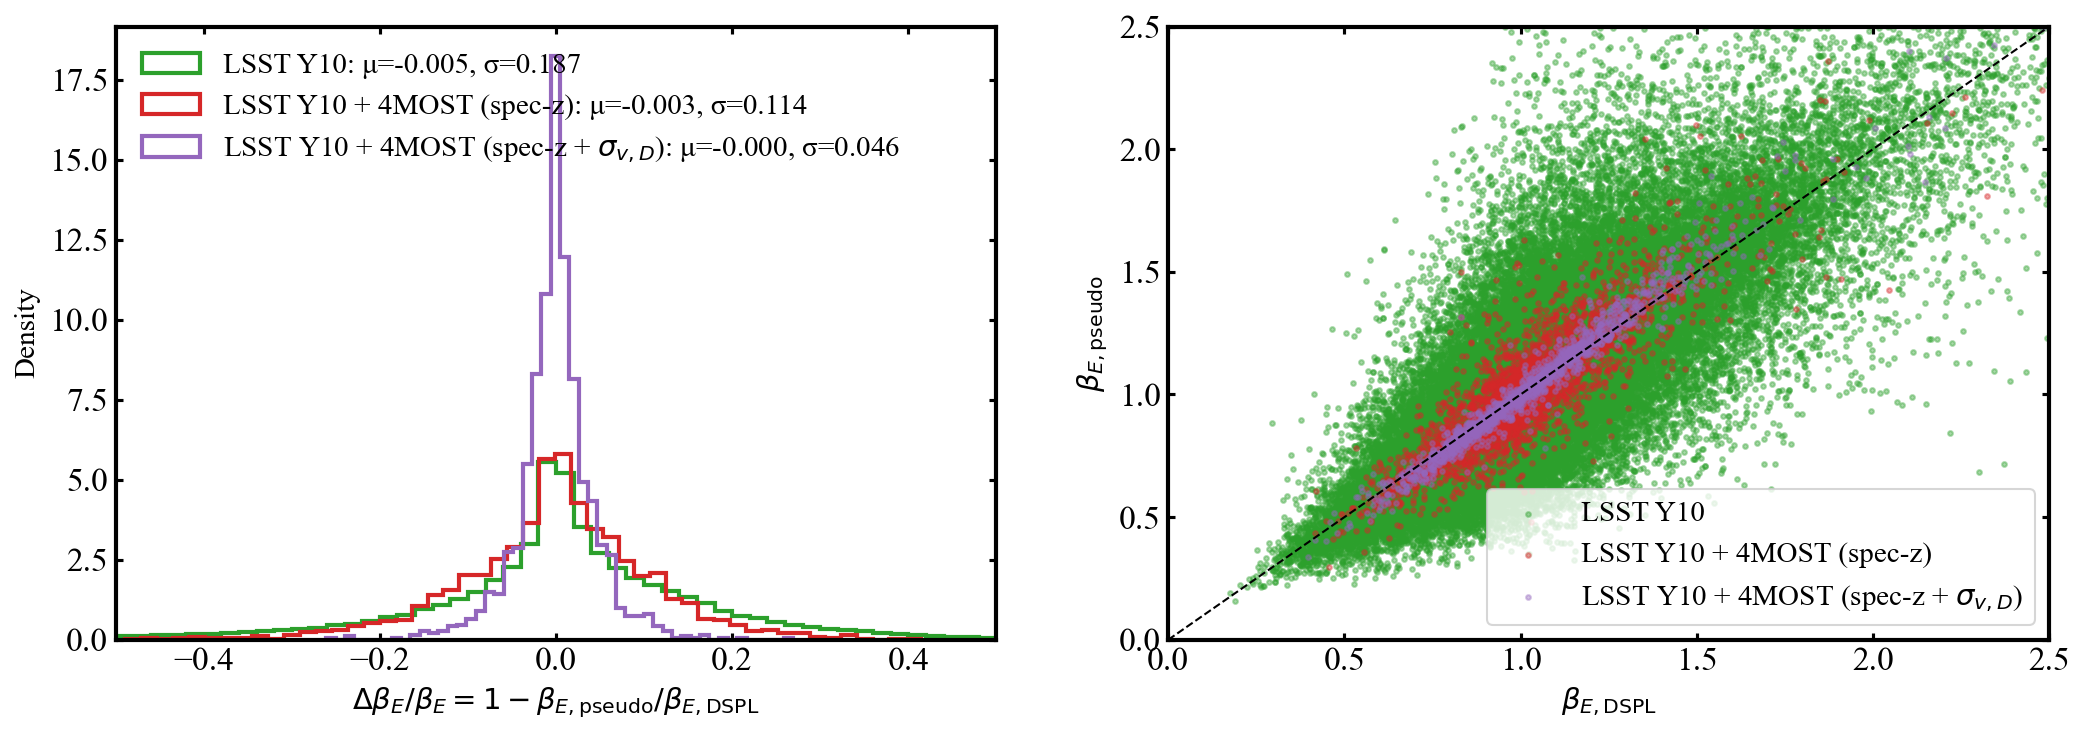

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
ax_hist, ax_scatter = axes

samples_to_plot = ["lsst_y10", 
                   "lsst_4most_spec-z", 
                   "lsst_4most_spec-z_sigma_v"]

for key in samples_to_plot:
    s = pdspl_samples[key]
    beta_DSPL = np.array(s['pairs_analysis']['pairs_table']["beta_E_DSPL"])
    beta_pseudo = np.array(s['pairs_analysis']['pairs_table']["beta_E_pseudo"])
    rel_diff = 1 - beta_pseudo / beta_DSPL

    sample_name = s['name']

    # Gaussian fit
    mu, sigma = np.mean(rel_diff), np.std(rel_diff)
    x_fit = np.linspace(np.min(rel_diff), np.max(rel_diff), 200)
    pdf = norm.pdf(x_fit, mu, sigma)
    
    # cut to range -0.5 to 0.5 for better visualization
    rel_diff = rel_diff[(rel_diff > -0.5) & (rel_diff < 0.5)]

    # Histogram with Gaussian overlay
    ax_hist.hist(
        rel_diff, bins=50, density=True, color=s['color'], linewidth=2, histtype='step',
        label=f"{sample_name}: μ={mu:.3f}, σ={sigma:.3f}"
    )
    # ax_hist.plot(x_fit, pdf, lw=1.5, color=s['color'])

    # Scatter plot
    ax_scatter.scatter(
        beta_DSPL, beta_pseudo, s=5, alpha=0.4, color=s['color'], label=sample_name
    )

# Format hist axis
ax_hist.set_xlabel(r"$\Delta\beta_E / \beta_E = 1 - \beta_{E,\mathrm{pseudo}} / \beta_{E,\mathrm{DSPL}}$", fontsize=14)
ax_hist.set_ylabel("Density", fontsize=14)
ax_hist.set_xlim(-0.5, 0.5)
ax_hist.legend(frameon=False, fontsize=14, loc='upper left')
# ax_hist.set_title("Distribution of relative β_E difference across samples")

# Format scatter axis
# ax_scatter.plot([0, np.max(beta_DSPL)], [0, np.max(beta_DSPL)], 'k--', lw=1, label=r"$y = x$")
ax_scatter.set_xlabel(r"$\beta_{E,\mathrm{DSPL}}$", fontsize=14)
ax_scatter.set_ylabel(r"$\beta_{E,\mathrm{pseudo}}$", fontsize=14)
ax_scatter.set_xlim(0, 2.5)
ax_scatter.set_ylim(0, 2.5)
# ax_scatter.set_title(r"$\beta_E$ comparison across samples")
ax_scatter.legend(frameon=False, fontsize=14)

# add a y=x line
ax_scatter.plot([0, 2.5], [0, 2.5], 'k--', lw=1)
ax_scatter.legend(frameon=True, fontsize=14)

# set tick parameters
ax_hist.tick_params(axis='both', which='major', labelsize=16)
ax_scatter.tick_params(axis='both', which='major', labelsize=16)

fig.tight_layout()

# save the figure
# fig.savefig(f"../figures/slsim_all_samples_beta_E_comparison.pdf", dpi=300)
# plt.savefig(f"../figures/slsim_all_samples_beta_E_comparison.png", dpi=300)

Fit for lsst_y10 (D<=0.06): sigma(D) = 2.759 * D + 0.101
weighted scatter in beta_E for lsst_y10:  0.043049723988987355
binned weighted scatter in beta_E for lsst_y10:  0.12954169437969776
Fit for lsst_4most_spec-z (D<=0.06): sigma(D) = 1.873 * D + 0.058
weighted scatter in beta_E for lsst_4most_spec-z:  0.025525737845456486
binned weighted scatter in beta_E for lsst_4most_spec-z:  0.07305670238499067
Fit for lsst_4most_spec-z_sigma_v (D<=0.06): sigma(D) = 0.886 * D + 0.027
weighted scatter in beta_E for lsst_4most_spec-z_sigma_v:  0.020131441484416028
binned weighted scatter in beta_E for lsst_4most_spec-z_sigma_v:  0.03269060908269437


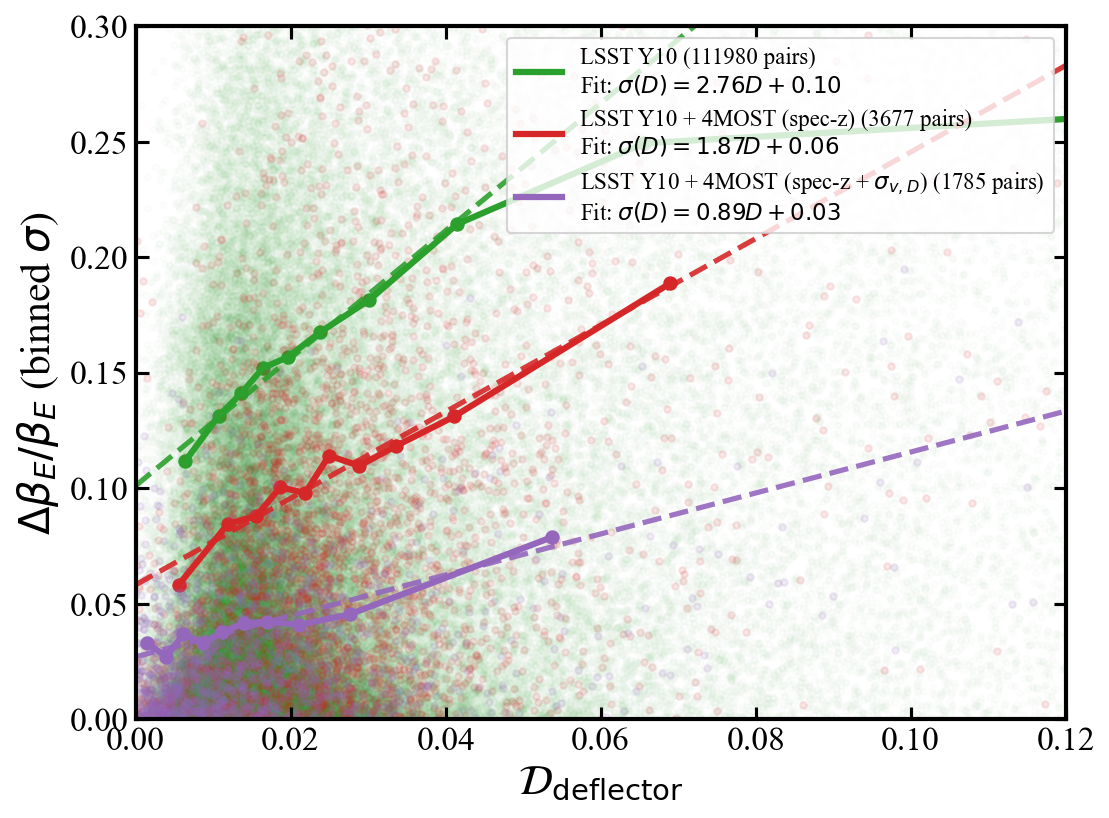

In [14]:
########################################################
### Define the linear model for fitting
########################################################
def linear_model(x, a, b):
    """
    A simple linear model: f(x) = a*x + b
    We use np.maximum to ensure the uncertainty is never negative.
    """
    return np.maximum(0, a * x + b)

########################################################
### Plot scatter in beta_E vs dissimilarity parameter binned
########################################################
fig, ax = plt.subplots(figsize=(8, 6))

samples_to_plot = ["lsst_y10", 
                   "lsst_4most_spec-z", 
                   "lsst_4most_spec-z_sigma_v"]

tranparencies_scatter_plot = {
    "lsst_y10": 0.01,
    "lsst_4most_spec-z": 0.1,
    "lsst_4most_spec-z_sigma_v": 0.12
}

for key in samples_to_plot:
    s = pdspl_samples[key]
    if "pairs_analysis" not in s:
        print(f"⚠️ Skipping {s['label']} (no pairs_analysis found)")
        continue

    pairs_table = s["pairs_analysis"]["pairs_table"]
    pairs_table_with_errors = s["pairs_analysis"]["pairs_table_with_errors"]
    
    num_pairs = len(pairs_table_with_errors)
    if num_pairs == 0:
        print(f"⚠️ Skipping {s['label']} (no pairs found)")
        continue

    # --- Compute dissimilarity dynamically ---
    diffs = np.array([pairs_table_with_errors[k] for k in s['dissimilarity_keys']])
    estimator = np.sqrt(np.mean(diffs**2, axis=0))

    beta_ratio = pairs_table["beta_E_pseudo"] / pairs_table["beta_E_DSPL"] # these values should be from true table to get the true scatter
    abs_scatter_beta_E = np.abs(1 - beta_ratio)

    # --- Quantile Binning Statistics ---
    n_bins = 10
    quantiles = np.linspace(0, 100, n_bins + 1)
    bins = np.percentile(estimator, quantiles)
    bins = np.unique(bins)
    digitized = np.digitize(estimator, bins)

    # Y-values: std dev of the (1 - ratio) in the bin
    bin_means_y = np.array([
        np.std(1 - beta_ratio[digitized == i]) for i in range(1, len(bins))
    ])
    
    # X-values: The mean dissimilarity (D) in the bin
    bin_means_x = np.array([
        np.mean(estimator[digitized == i]) for i in range(1, len(bins))
    ])

    # Clean NaNs that might arise from empty bins
    valid_mask = ~np.isnan(bin_means_x) & ~np.isnan(bin_means_y)
    bin_means_x_clean = bin_means_x[valid_mask]
    bin_means_y_clean = bin_means_y[valid_mask]

    # --- NEW: Create a mask for the linear fit (D <= 0.06) ---
    fit_mask = bin_means_x_clean <= 0.06
    bin_means_x_for_fit = bin_means_x_clean[fit_mask]
    bin_means_y_for_fit = bin_means_y_clean[fit_mask]
    # --- END NEW ---

    # --- Fit a linear model to the binned statistics (using filtered data) ---
    fit_label_str = "Fit: N/A"
    # Check if we have at least 2 points *to fit*
    if len(bin_means_x_for_fit) > 1: 
        try:
            initial_guess = [1.0, 0.01]
            # Use only the data for fitting (D <= 0.06)
            popt, pcov = curve_fit(linear_model, 
                                   bin_means_x_for_fit, 
                                   bin_means_y_for_fit, 
                                   p0=initial_guess)
            fit_a, fit_b = popt

            # Generate line data for plotting (across the whole range)
            D_line = np.linspace(0, 0.12, 100)
            fit_line = linear_model(D_line, fit_a, fit_b)
            
            # Plot the fitted line as a dashed line
            ax.plot(
                D_line, 
                fit_line, 
                color=s["color"], 
                lw=2.5, 
                ls='--', # Dashed line style
                alpha=0.9
            )
            fit_label_str = f"Fit: $\\sigma(D) = {fit_a:.2f}D + {fit_b:.2f}$"
            print(f"Fit for {key} (D<=0.06): sigma(D) = {fit_a:.3f} * D + {fit_b:.3f}")

        except RuntimeError as e:
            print(f"    ⚠️ Could not fit line for {key}: {e}")
            
    # --- Plotting ---
    
    # Plot the raw scatter plot in the background
    ax.scatter(
        estimator,
        abs_scatter_beta_E,
        color=s["color"],
        s=10,
        alpha=tranparencies_scatter_plot[key], # Very transparent
        label=None # No legend entry for the raw data
    )

    # Plot the binned data (scatter points) - full range
    ax.scatter(
        bin_means_x,
        bin_means_y,
        color=s["color"],
        s=35,
        label=None # No legend entry for the points
    )
    
    # Plot the binned data (solid line) - full range
    # This line will carry the full legend entry
    ax.plot(
        bin_means_x,
        bin_means_y,
        color=s["color"],
        lw=3,
        label=f"{s['name']} ({num_pairs} pairs)\n{fit_label_str}"
    )

    # --- Weighted scatter calculation (unchanged) ---
    clean_idxs = (estimator > 0) & (abs_scatter_beta_E > 0)
    abs_scatter_beta_E_clean = abs_scatter_beta_E[clean_idxs]
    estimator_clean = estimator[clean_idxs]

    if len(estimator_clean) > 0:
        weighted_scatter = np.sum(abs_scatter_beta_E_clean / estimator_clean**2) / np.sum(1 / estimator_clean**2)
        print(f"weighted scatter in beta_E for {key}: ", weighted_scatter)
        # binned weighted scatter
        binned_weighted_scatter = np.sum(bin_means_y / bin_means_x**2) / np.sum(1 / bin_means_x**2)
        print(f"binned weighted scatter in beta_E for {key}: ", binned_weighted_scatter)
    


# --- Axis formatting ---
ax.set_xlabel(r'$\mathcal{D}_{\rm deflector}$', fontsize=20)
ax.set_ylabel(r'${\Delta \beta_E}/{\beta_E}$ (binned $\sigma$)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16, length=6, width=1.5)
ax.set_xlim(0, 0.12)
ax.set_ylim(0, 0.3)
ax.legend(fontsize=11, frameon=True, loc='upper right')
########################################################

In [ ]:
########################################################
### Plot scatter in beta_E vs dissimilarity parameter 
########################################################
fig, ax = plt.subplots(figsize=(8, 6))

samples_to_plot = ["lsst_y10", 
                   "lsst_4most_spec-z", 
                   "lsst_4most_spec-z_sigma_v"]

for key in samples_to_plot:
    s = pdspl_samples[key]
    if "pairs_analysis" not in s:
        print(f"⚠️ Skipping {s['label']} (no pairs_analysis found)")
        continue

    pairs_table = s["pairs_analysis"]["pairs_table"]

    if len(pairs_table) == 0:
        print(f"⚠️ Skipping {s['label']} (no pairs found)")
        continue

    print(f"Plotting for {s['label']} with {len(pairs_table)} pairs")

    # --- Compute dissimilarity dynamically ---
    diffs = np.array([pairs_table[k] for k in s['dissimilarity_keys']])
    estimator = np.sqrt(np.mean(diffs**2, axis=0))

    beta_ratio = pairs_table["beta_E_pseudo"] / pairs_table["beta_E_DSPL"]
    scatter_in_beta_E = np.abs(1 - beta_ratio)

    ax.scatter(
        estimator,
        scatter_in_beta_E,
        color=s["color"],
        label=f"{s['name']}\n{len(pairs_table)} pairs",
        alpha=0.5,
        s=10
    )
# --- Axis formatting ---
ax.set_xlabel(r'$\mathcal{D}_{\rm deflector}$', fontsize=20)
ax.set_ylabel(r'${\Delta \beta_E}/{\beta_E}$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16, length=6, width=1.5)
ax.set_xlim(0, 0.12)
ax.set_ylim(0, 0.5)
ax.legend(fontsize=12, frameon=True, loc='upper left')

In [65]:
test_table = pdspl_samples['lsst_y10']['pairs_analysis']['pairs_table']
test_table = test_table[np.abs(test_table['z_D1'] - test_table['z_D2']) < 0.002]
test_table[test_table['beta_E_pseudo'] > 1]['z_D1', 'z_D2', 'z_D', 'z_S1', 'z_S2', 'beta_E_DSPL', 'beta_E_pseudo']

<Table length=2768>
       z_D1                z_D2        ...    beta_E_DSPL       beta_E_pseudo   
     float64             float64       ...      float64            float64      
------------------ ------------------- ... ------------------ ------------------
0.5729463797976478  0.5712667934493778 ... 0.9934478510523557 1.0321870225663385
0.8047544778470371  0.8051113369758596 ... 0.8698112129371638  1.230193576227384
1.8914380237425117  1.8929744953767422 ... 0.9912663159506919 1.0298207952847653
0.9039955725833868  0.9022789980781263 ... 0.9684908933214543 1.2062250572377982
0.8361821131976249   0.835374742607379 ... 0.9747958255915878   1.34260741404711
1.9647275623983076  1.9655230263201515 ... 0.9956994980471722 1.4726902502144195
0.7653369183551653  0.7655951675967299 ... 0.9647968436056771 1.0070118017774998
1.0027147581513045  1.0028068855208367 ... 0.8524189396311503 1.2244748494663704
0.9888088277877647  0.9879888238010085 ...  0.935151675862781 1.1403355371876682
               ...                 ... ...                ...                ...
  1.49617889970147  1.4954581431590446 ... 0.9690317613220095 1.0863960985834684
 0.895447868940195  0.8959295414065572 ... 0.9504649715723779 1.0879077716214354
1.4529094933656392  1.4521778852316045 ... 0.9856855339557515  1.297922813458033
1.6581992153896794   1.657220187047465 ...   0.92528018265597 1.0017125846733297
2.0298759114981046   2.029186958041318 ... 0.9947602898730123 1.3705999748747733
 0.472680043716888 0.47291167236743403 ... 0.9911387708057485 1.0439796807205732
 1.015351555230193   1.014179488817244 ... 0.9920254847366331 1.0097834608063327
1.0838757025074393  1.0850999966956418 ... 0.9862650055316402 1.1755863680866792
 2.101049478831444  2.1015723524547956 ... 0.9134844404124824 1.4096711514441334
0.3239228321996957 0.32514162278688163 ... 0.9655872304714833 1.1643927391241031

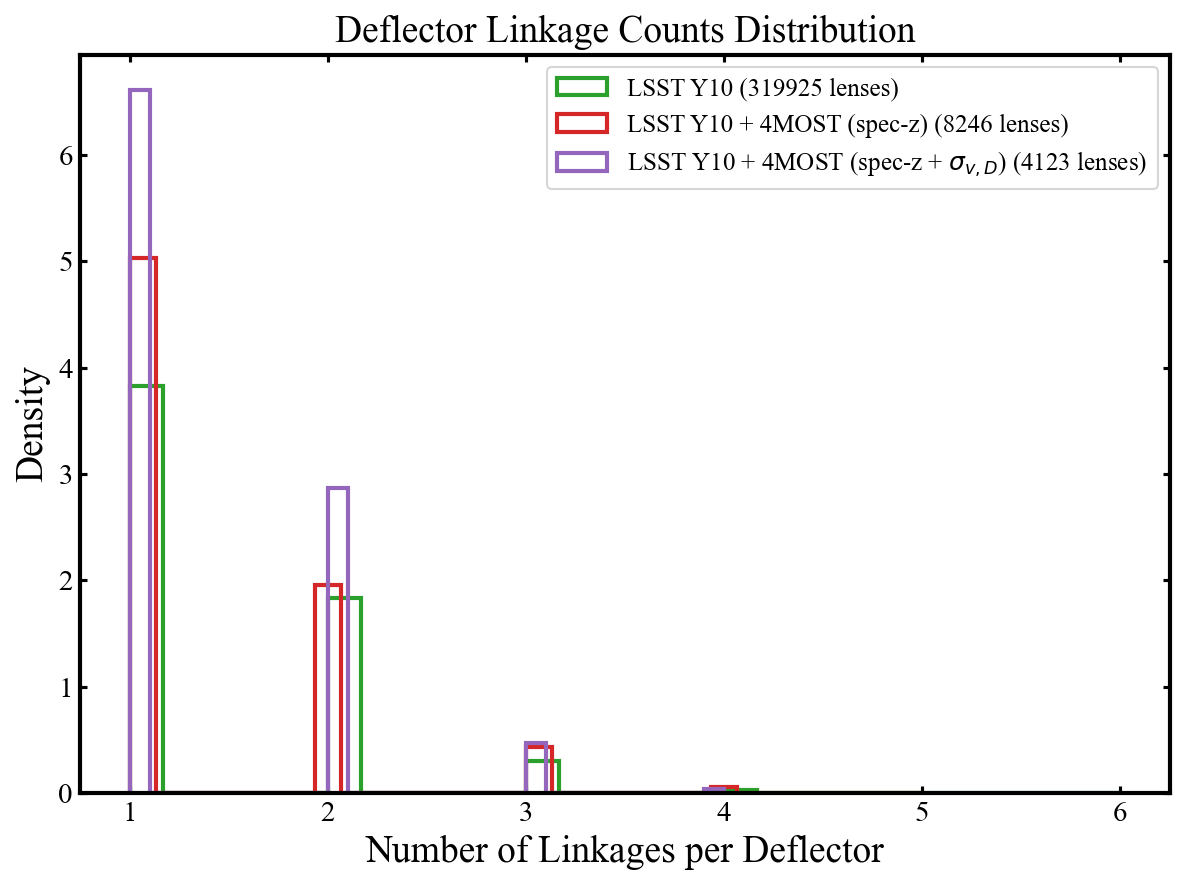

In [68]:
##################################################
###  Histogram of linkage counts
##################################################

samples_to_plot = ["lsst_y10", 
                   "lsst_4most_spec-z", 
                   "lsst_4most_spec-z_sigma_v"]

fig, ax = plt.subplots(figsize=(8, 6))

for key in samples_to_plot:
    s = pdspl_samples[key]
    counts = s['pairs_analysis']['linkage_counts']
    ax.hist(
        counts,
        bins=30,
        density=True,
        histtype='step',
        linewidth=2,
        label=f"{s['name']} ({len(s['table'])} lenses)",
        color=s['color']
    )
ax.set_xlabel("Number of Linkages per Deflector")
ax.set_ylabel("Density")
# ax.set_yscale("log")
ax.set_title("Deflector Linkage Counts Distribution")
ax.legend(fontsize=12)
fig.tight_layout()

mean links for a single deflector: 2.0


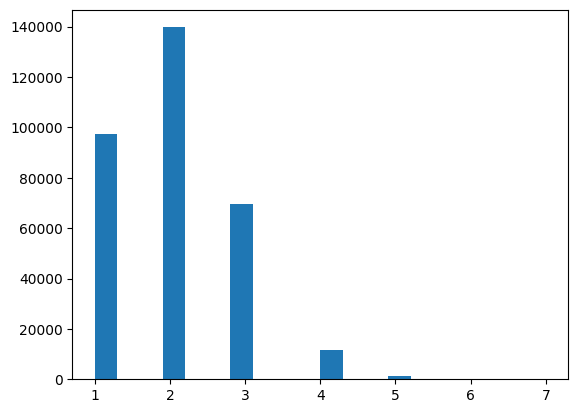

## Various Samples

In [16]:
print('----------------------------------')
print("Sky area:", sky_area, "deg^2")
print('----------------------------------')
print("SLSim (i < 28, contrast_ratio > 2, mu_tot > 3)  # lenses:", len(GGL_data_table))
print("Y1  (i < 24.0)              # lenses:", np.sum(lsst_1_yr_coadd_mag_depth_mask))
print("Y10 (i < 25.8)              # lenses:", np.sum(lsst_10_yr_coadd_mag_depth_mask))
# print("4MOST (z_S < 1.5)                      # lenses:", np.sum(lsst_4MOST_mag_depth_mask))
print("4MOST (r < 24 & z_S < 1.5)  # lenses:", np.sum(lsst_4MOST_mag_depth_mask))
print('----------------------------------')
print()
print('----------------------------------')
print("Sky area:", 20000, "deg^2")
print('----------------------------------')
print("Y1    # lenses:", np.sum(lsst_1_yr_coadd_mag_depth_mask)*20000/float(sky_area))
print("Y10   # lenses:", np.sum(lsst_10_yr_coadd_mag_depth_mask)*20000/float(sky_area))
print("4MOST # lenses:", np.sum(lsst_4MOST_mag_depth_mask)*20000/float(sky_area))
print('----------------------------------')

----------------------------------
Sky area: 20000.0 deg^2
----------------------------------
SLSim (i < 28, contrast_ratio > 2, mu_tot > 3)  # lenses: 322403
Y1  (i < 24.0)              # lenses: 188902
Y10 (i < 25.8)              # lenses: 319925
4MOST (r < 24 & z_S < 1.5)  # lenses: 8246
----------------------------------

----------------------------------
Sky area: 20000 deg^2
----------------------------------
Y1    # lenses: 188902.0
Y10   # lenses: 319925.0
4MOST # lenses: 8246.0
----------------------------------


In [17]:
# get pairs table for all GGL samples
cosmo_true = FlatLambdaCDM(H0=70, Om0=0.3)

keys_to_pair_deflectors = [
    'z_D',
    'R_e_kpc',
    # 'mag_D_g',
    # 'mag_D_r',
    'mag_D_i',
    # 'mag_D_z',
    # 'mag_D_y',
    # 'e_mass_D',
    # 'Sigma_half_Msun/pc2',
    # 'surf_bri_mag/arcsec2',
    # 'stellar_mass_D',
    'color_D_gr',
    'color_D_ri',
]

keys_to_pair_deflectors_latex = {
    'z_D': r'$z_{\mathrm{lens}}$',
    'R_e_kpc': r'$R_e$ [kpc]',
    'mag_D_g': r'$m_g$',
    'mag_D_r': r'$m_r$',
    'mag_D_i': r'$m_i$',
    'mag_D_z': r'$m_z$',
    'mag_D_y': r'$m_y$',
    'Sigma_half_Msun/pc2': r'$\Sigma_{1/2}$ [$M_\odot/\mathrm{pc}^2$]',
    'surf_bri_mag/arcsec2': r'$\mu_{1/2}$ [mag/$\mathrm{arcsec}^2$]',
    'stellar_mass_D': r'$\log(M_*/M_\odot)$',
    'e_mass_D': r'$\varepsilon_{D}$',
    'color_D_gr': r'$m_g - m_r$',
    'color_D_ri': r'$m_r - m_i$',
}


## 1. GGL_data_table all
points_all = np.stack([
    normalize_data(table[key], type='zscore') for key in keys_to_pair_deflectors    
    ],
    axis=1)
pair_indices_all, _ = kdtree_matching_n_dim(points=points_all, n_neighbors=2, unique_pairs=True)
pairs_table_all = get_pairs_table_PDSPL(GGL_data_table, pair_indices=pair_indices_all, cosmo=cosmo_true)


## 2. lsst_1_yr_GGL_table
points_1yr = np.stack([
    normalize_data(lsst_1_yr_GGL_table[key], type='zscore') for key in keys_to_pair_deflectors    
    ],
    axis=1)
pair_indices_1yr, _ = kdtree_matching_n_dim(points=points_1yr, n_neighbors=2, unique_pairs=True)
pairs_table_1yr = get_pairs_table_PDSPL(lsst_1_yr_GGL_table, pair_indices=pair_indices_1yr, cosmo=cosmo_true)

## 3. lsst_10_yr_GGL_table
points_10yr = np.stack([
    normalize_data(lsst_10_yr_GGL_table[key], type='zscore') for key in keys_to_pair_deflectors
    ],
    axis=1)
pair_indices_10yr, _ = kdtree_matching_n_dim(points=points_10yr, n_neighbors=2, unique_pairs=True)
pairs_table_10yr = get_pairs_table_PDSPL(lsst_10_yr_GGL_table, pair_indices=pair_indices_10yr, cosmo=cosmo_true)

## 4. lsst_4MOST_GGL_table
points_4MOST = np.stack([
    normalize_data(lsst_4MOST_GGL_table[key], type='zscore') for key in keys_to_pair_deflectors
    ],
    axis=1)
pair_indices_4MOST, _ = kdtree_matching_n_dim(points=points_4MOST, n_neighbors=2, unique_pairs=True)
pairs_table_4MOST = get_pairs_table_PDSPL(lsst_4MOST_GGL_table, pair_indices=pair_indices_4MOST, cosmo=cosmo_true)

Processing pairs: 100%|██████████| 5619/5619 [00:00<00:00, 7761.08it/s]


In [18]:
# print number of pairs and also how many lenses lead to those pairs
print('----------------------------------------------------------------------------------')
print('Expected near identical deflector pairs using KDTree')
print('----------------------------------------------------------------------------------')
print("Total      (g < 28)                         # lens pairs:", len(pairs_table_all), "from", len(GGL_data_table), "lenses")
print("LSST Y1    (g < 25.0 | r < 24.7 | i < 24.0) # lens pairs:", len(pairs_table_1yr), "from", len(lsst_1_yr_GGL_table), "lenses")
print("LSST 10 YR (g < 25.0 | r < 24.7 | i < 24.0) # lens pairs:", len(pairs_table_10yr), "from", len(lsst_10_yr_GGL_table), "lenses")
print("LSST 4MOST (g < 25.0 | r < 24.7 | i < 24.0) # lens pairs:", len(pairs_table_4MOST), "from", len(lsst_4MOST_GGL_table), "lenses")
print('----------------------------------------------------------------------------------')

----------------------------------------------------------------------------------
Expected near identical deflector pairs using KDTree
----------------------------------------------------------------------------------
Total      (g < 28)                         # lens pairs: 227802 from 322403 lenses
LSST Y1    (g < 25.0 | r < 24.7 | i < 24.0) # lens pairs: 135071 from 188902 lenses
LSST 10 YR (g < 25.0 | r < 24.7 | i < 24.0) # lens pairs: 227802 from 319925 lenses
LSST 4MOST (g < 25.0 | r < 24.7 | i < 24.0) # lens pairs: 5619 from 8246 lenses
----------------------------------------------------------------------------------


Plotting for All (g < 28) with 227802 pairs
Plotting for LSST Single Visit Depth with 135071 pairs
Plotting for LSST Y10-like Depth with 227802 pairs
Plotting for LSST Y10 + 4MOST spec-z with 5619 pairs


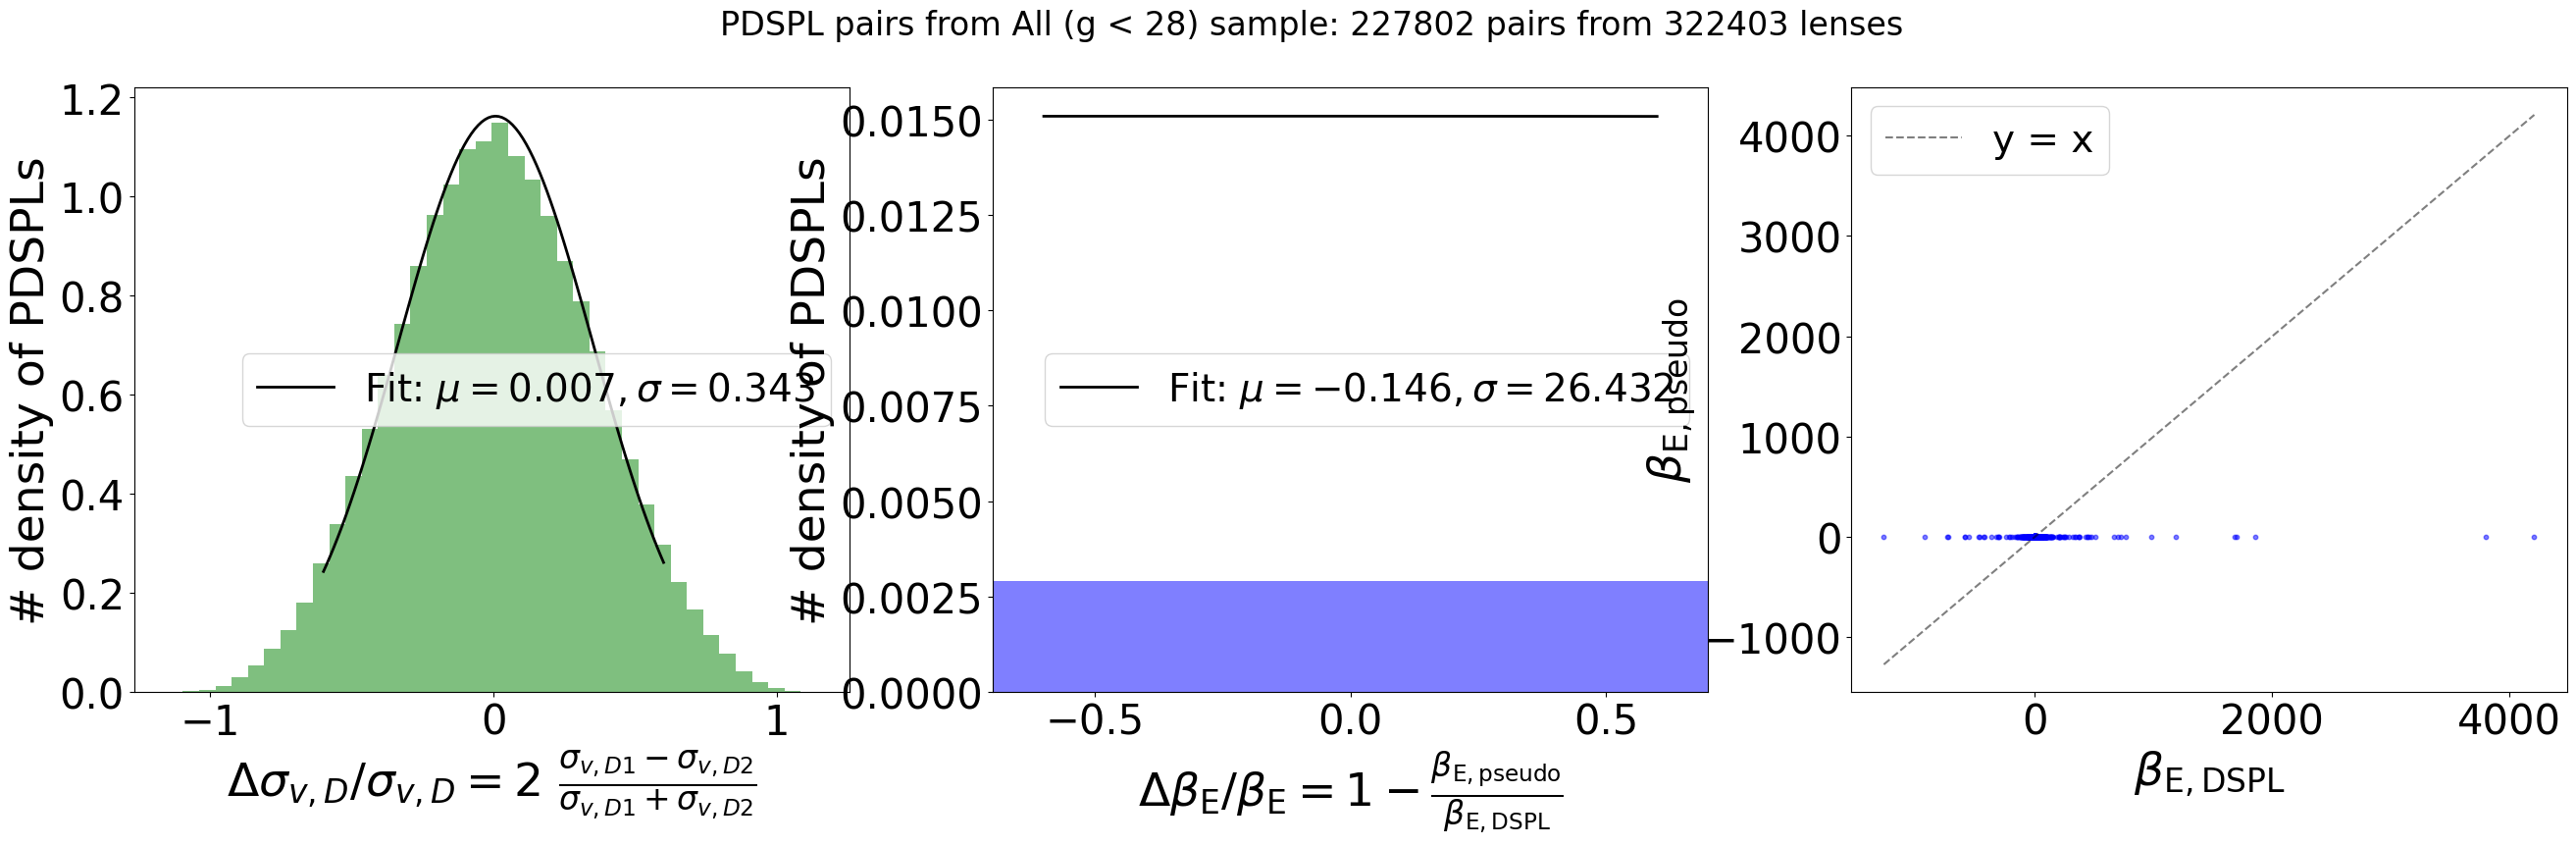

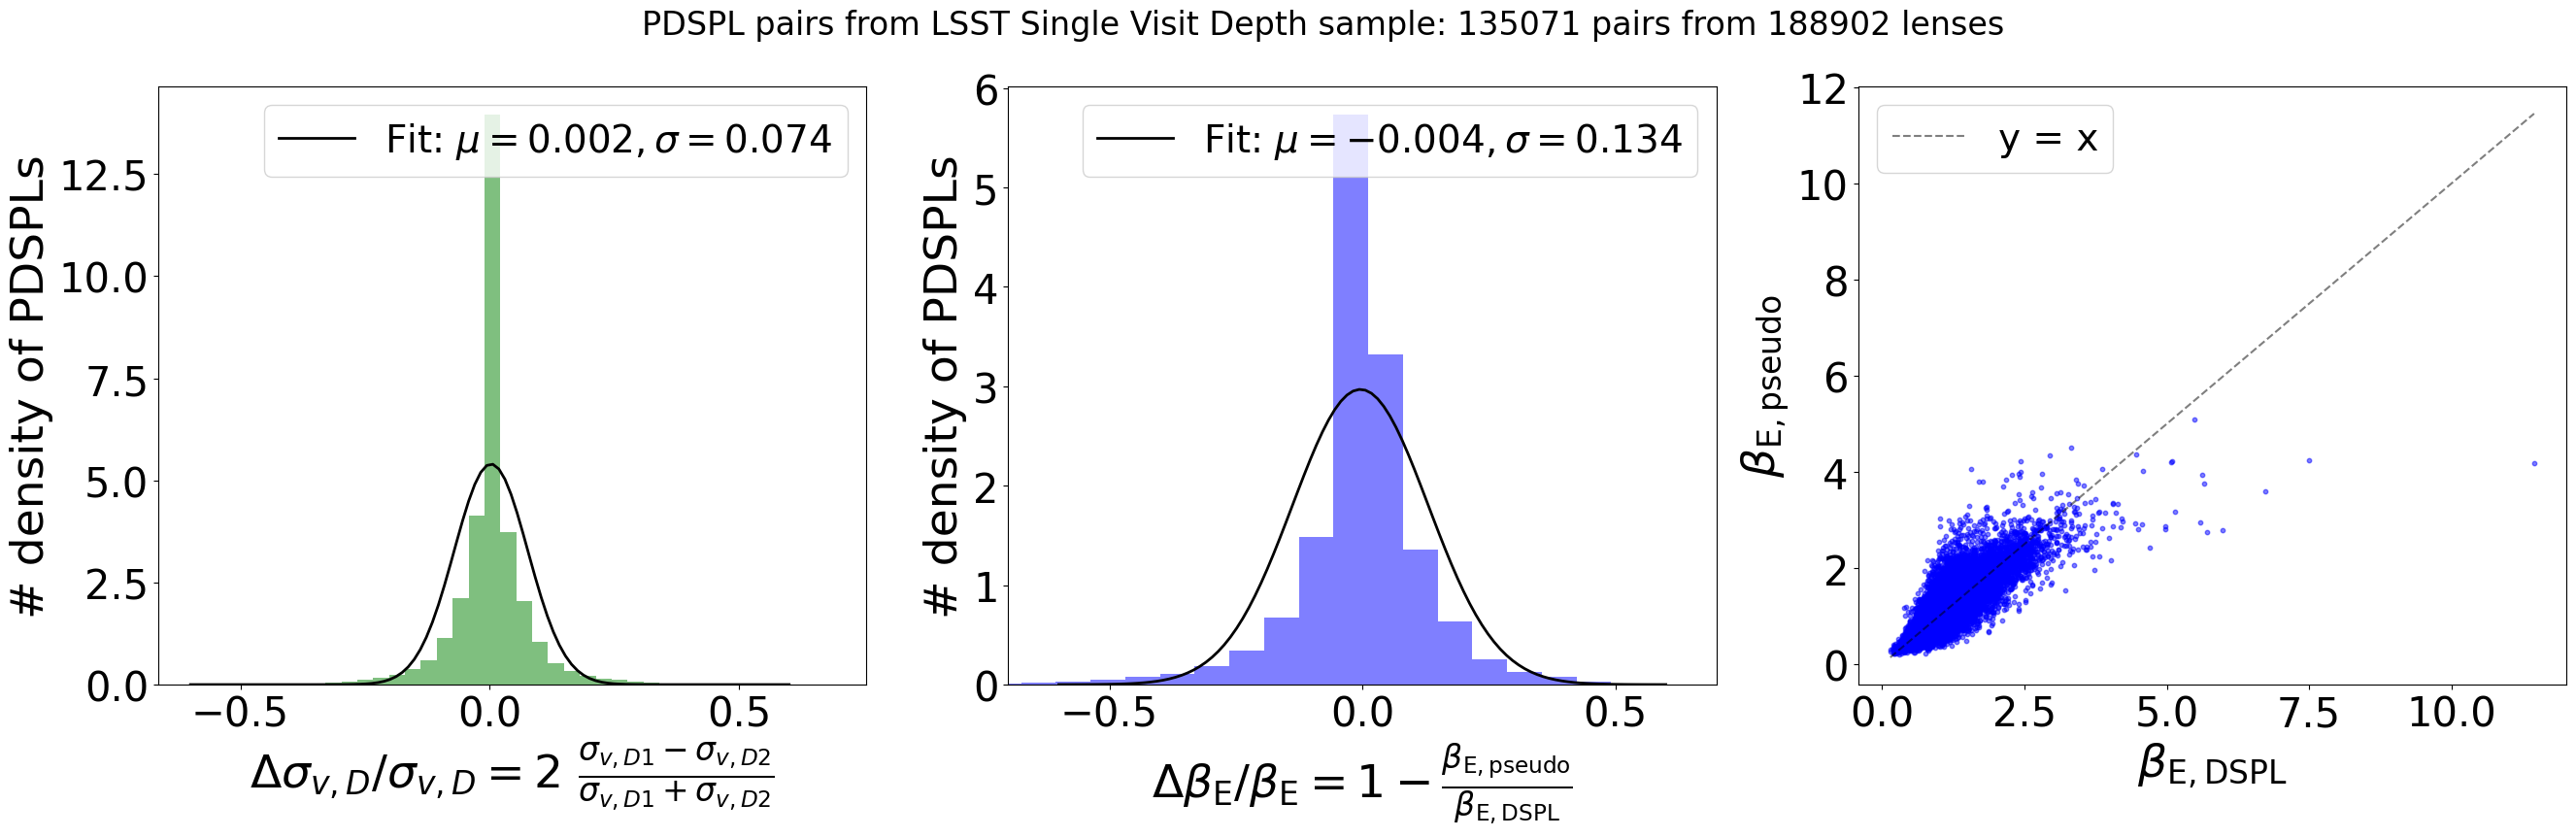

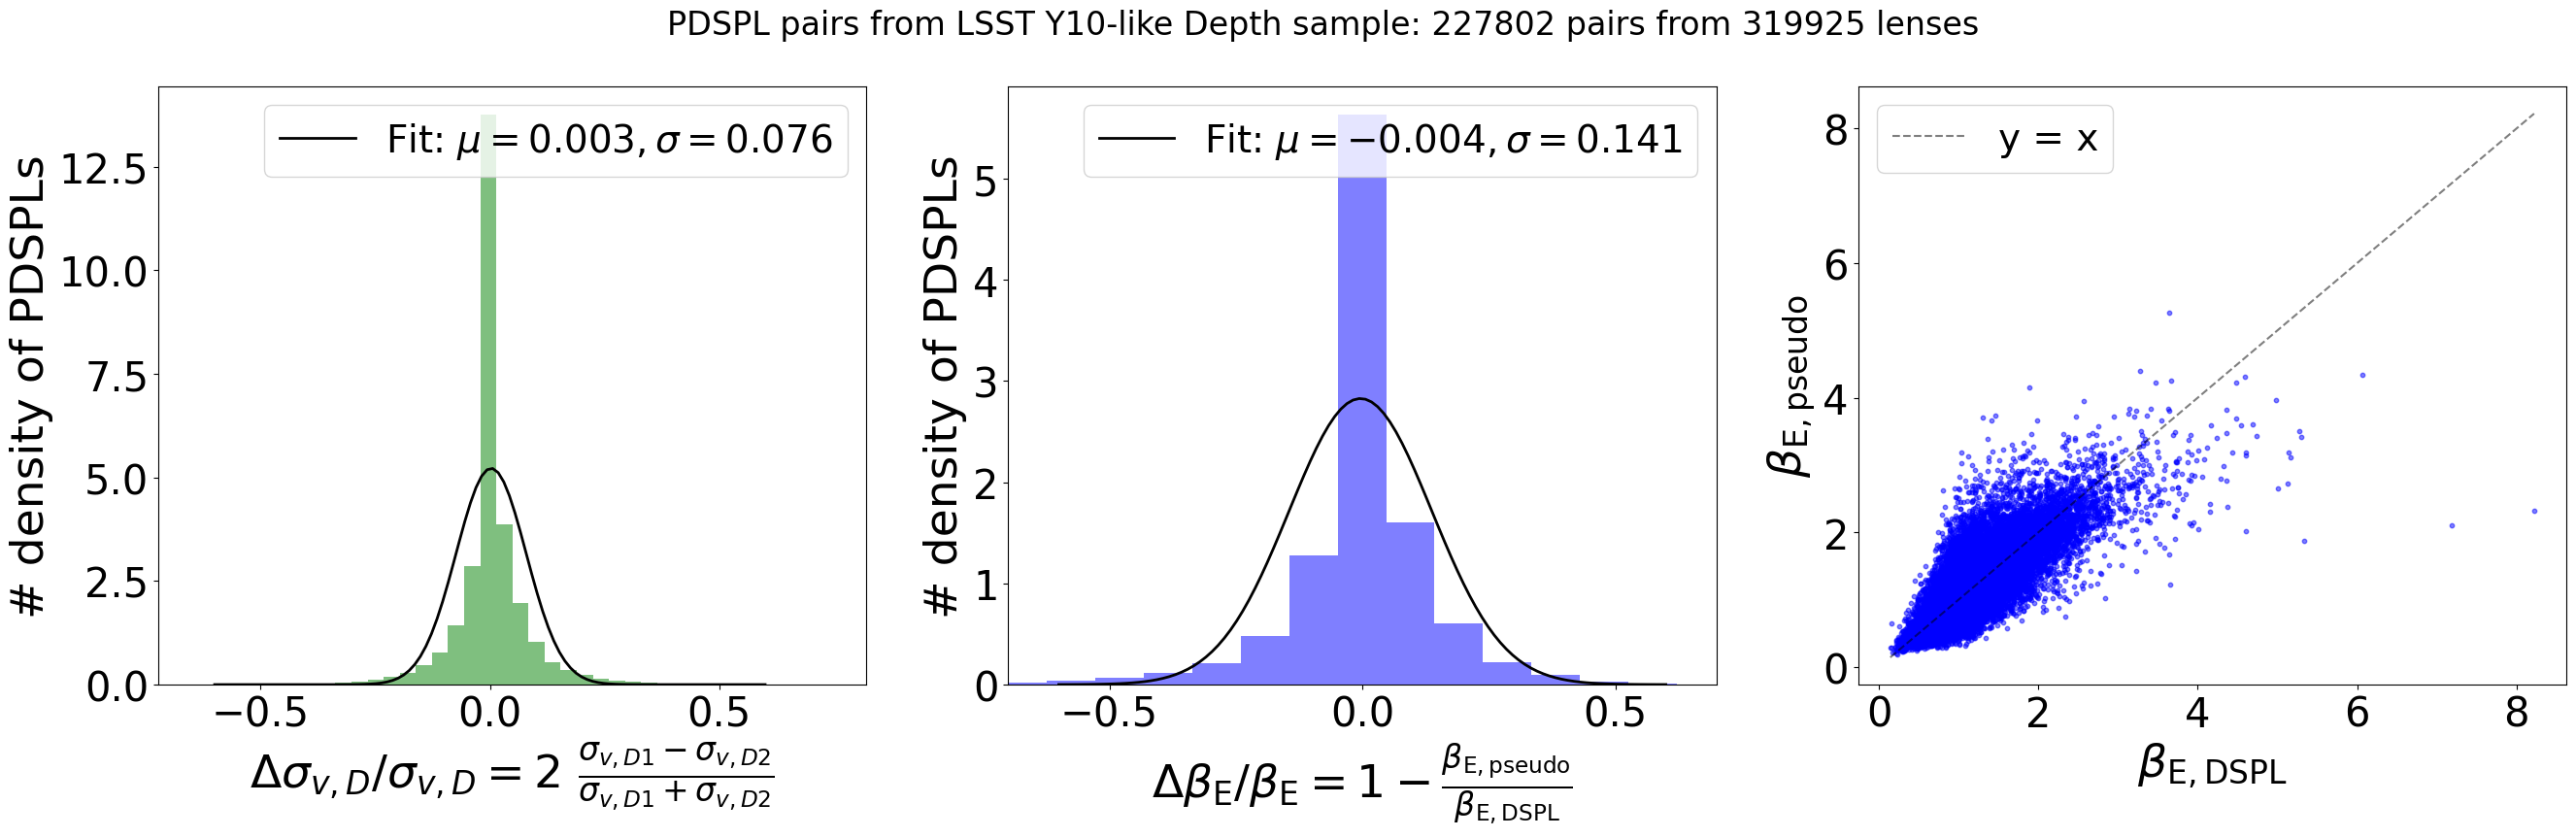

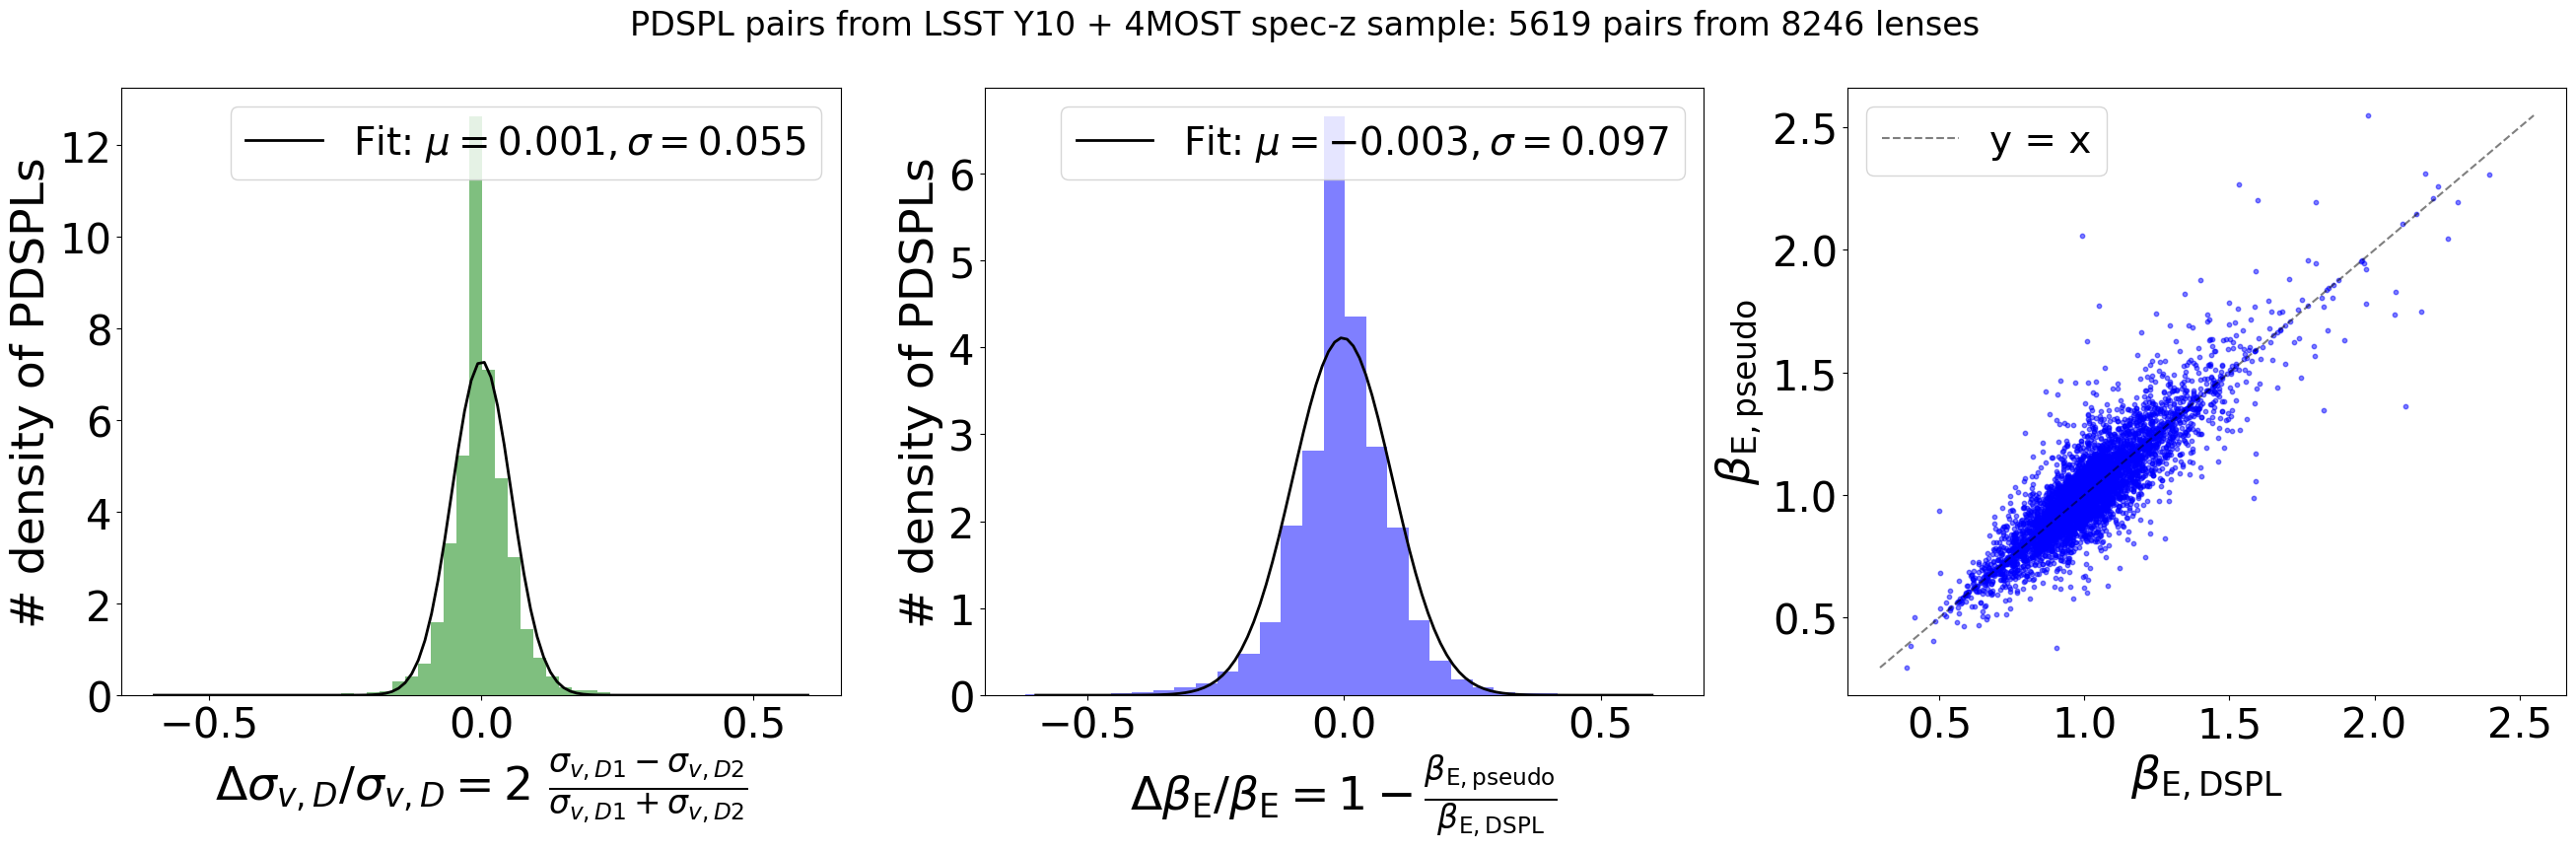

In [19]:

for pairs_table, label, data_table in zip([pairs_table_all, pairs_table_1yr, pairs_table_10yr, pairs_table_4MOST],
                              ['All (g < 28)', 'LSST Single Visit Depth', 'LSST Y10-like Depth', 'LSST Y10 + 4MOST spec-z'],
                              [GGL_data_table, lsst_1_yr_GGL_table, lsst_10_yr_GGL_table, lsst_4MOST_GGL_table]):
    print(f'Plotting for {label} with {len(pairs_table)} pairs')
    # histogram of the relative scatter in beta_E and sigma_v_D
    fig, axs = plt.subplots(1, 3, figsize=(32, 8))

    # set suptitle
    fig.suptitle(f'PDSPL pairs from {label} sample: {len(pairs_table)} pairs from {len(data_table)} lenses', fontsize=24)


    # First histogram: relative scatter in sigma_v_D
    axs[0].hist(
        pairs_table['rel_diff_sigma_v_D'],
        bins=40, color='green', alpha=0.5, density=True
    )
    axs[0].set_xlabel(r'$\Delta \sigma_{v,D} / \sigma_{v,D} = 2 \ \frac{\sigma_{v,D1} - \sigma_{v,D2}}{\sigma_{v,D1} + \sigma_{v,D2}}$', fontsize=16)
    axs[0].set_ylabel('# density of PDSPLs', fontsize=16)
    axs[0].tick_params(axis='both', which='major', labelsize=14)
    # axs[0].set_xlim(-0.3, 0.3)

    # fit a gaussian to the histogram
    mu, std = norm.fit(
        pairs_table['rel_diff_sigma_v_D']
    )
    x = np.linspace(-0.6, 0.6, 100)
    p = norm.pdf(x, mu, std)
    axs[0].plot(x, p, 'k', linewidth=2, label=f'Fit: $\\mu={mu:.3f}, \\sigma={std:.3f}$')
    axs[0].legend(fontsize=14)

    # Second histogram: relative scatter in beta_E
    axs[1].hist(pairs_table['rel_diff_beta_E'], bins=40, 
                color='blue', alpha=0.5, density=True)
    axs[1].set_xlabel(r'$\Delta \beta_{\rm E} / \beta_{\rm E} = 1 - \frac{\beta_{\rm E,pseudo}}{\beta_{\rm E,DSPL}}$', fontsize=16)
    axs[1].set_ylabel('# density of PDSPLs', fontsize=16)
    axs[1].tick_params(axis='both', which='major', labelsize=14)
    # axs[1].set_xlim(-0.3, 0.3)

    # fit a gaussian to the histogram
    mu_beta, std_beta = norm.fit(pairs_table['rel_diff_beta_E'])
    x_beta = np.linspace(-0.6, 0.6, 100)
    p_beta = norm.pdf(x_beta, mu_beta, std_beta)
    axs[1].plot(x_beta, p_beta, 'k', linewidth=2, label=f'Fit: $\\mu={mu_beta:.3f}, \\sigma={std_beta:.3f}$')
    axs[1].legend(fontsize=14)
    axs[1].set_xlim(-0.7, 0.7)

    # Third plot: beta_E_pseudo vs beta_E_DSPL
    axs[2].scatter(pairs_table['beta_E_DSPL'], pairs_table['beta_E_pseudo'], 
                alpha=0.5, s=10, color='blue')
    axs[2].set_xlabel(r'$\beta_{\rm E,DSPL}$', fontsize=16)
    axs[2].set_ylabel(r'$\beta_{\rm E,pseudo}$', fontsize=16)
    axs[2].tick_params(axis='both', which='major', labelsize=14)

    # Plot y = x line
    min_val = min(np.min(pairs_table['beta_E_DSPL']), np.min(pairs_table['beta_E_pseudo']))
    max_val = max(np.max(pairs_table['beta_E_DSPL']), np.max(pairs_table['beta_E_pseudo']))
    axs[2].plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='y = x')
    axs[2].legend(fontsize=14)


    # change tick and label sizes
    for ax in axs:
        ax.tick_params(axis='both', which='major', labelsize=30)
        ax.xaxis.label.set_size(34)
        ax.yaxis.label.set_size(34)
        # make title font size larger
        ax.title.set_fontsize(28)

        # legend font size
        if ax.get_legend() is not None:
            ax.legend(fontsize=28)

Plotting for LSST Y10-like Depth with 227802 pairs
Plotting for LSST Y10 + 4MOST spec-z with 5619 pairs


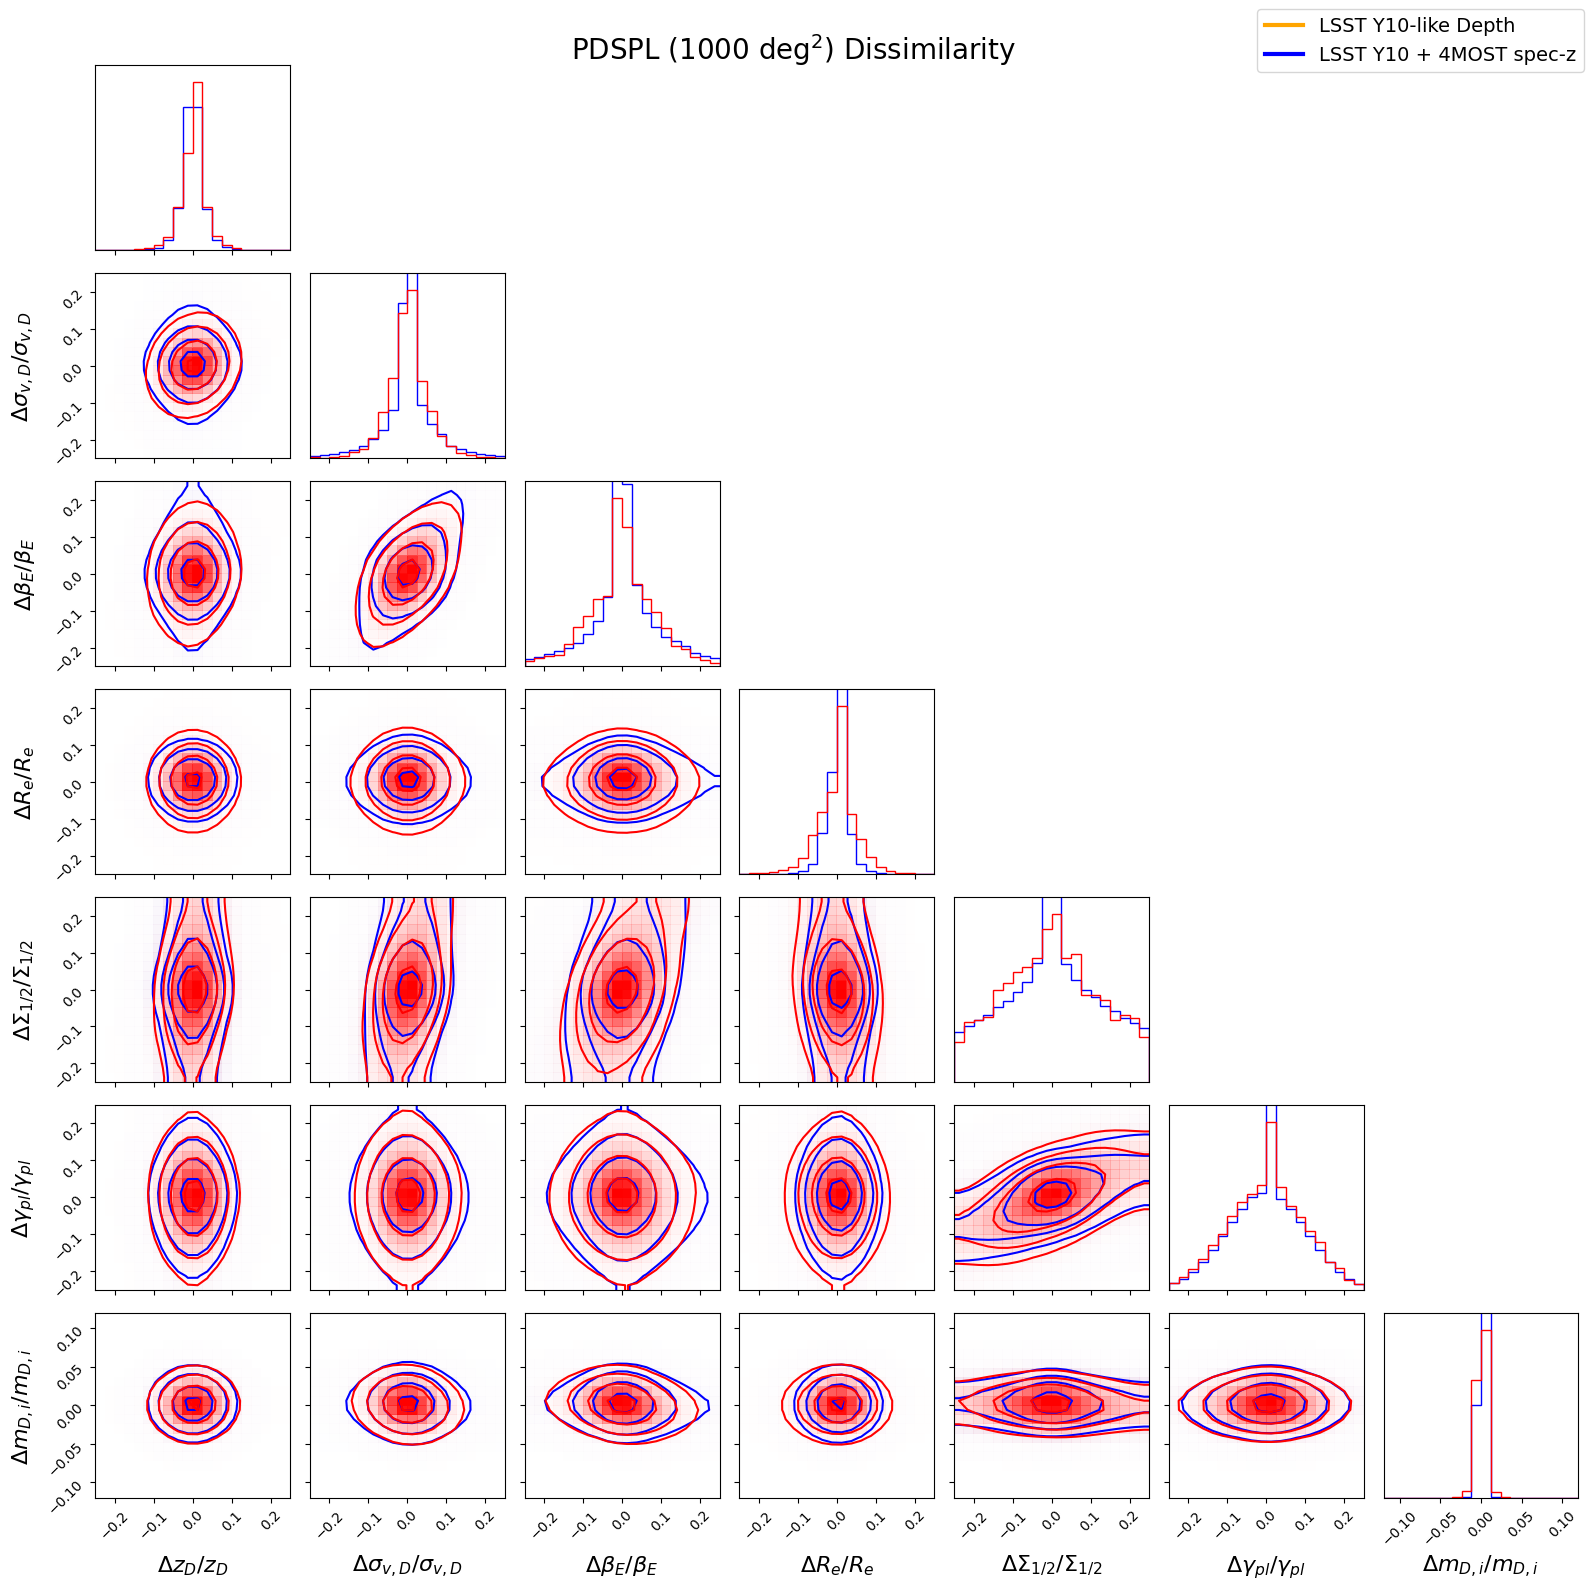

In [20]:
import corner

colors = [
        # 'purple', 
        'orange', 'blue', 'red']

# define labels once
corner_labels = [
    r'$\Delta z_{D} / z_{D}$',
    r'$\Delta \sigma_{v,D} / \sigma_{v,D}$',
    r'$\Delta \beta_{E} / \beta_{E}$',
    r'$\Delta R_{e} / R_{e}$',
    r'$\Delta \Sigma_{1/2} / \Sigma_{1/2}$',
    r'$\Delta \gamma_{pl} / \gamma_{pl}$',
    r'$\Delta m_{D,i} / m_{D,i}$',
]

indexes_to_plot = [1, 2]

figure = None  # start with no figure

i = -1
for pairs_table, label, data_table, color in zip(
    [
        # pairs_table_all, 
     pairs_table_1yr, pairs_table_10yr, pairs_table_4MOST],
    [
        # 'All (g < 28)', 
        'LSST Single Visit Depth', 'LSST Y10-like Depth', 'LSST Y10 + 4MOST spec-z'],
    [
        # GGL_data_table, 
        lsst_1_yr_GGL_table, lsst_10_yr_GGL_table, lsst_4MOST_GGL_table],
    colors
):
    i += 1
    if i not in indexes_to_plot:
        continue
    print(f'Plotting for {label} with {len(pairs_table)} pairs')

    corner_data = np.vstack([
        pairs_table['rel_diff_z_D'],
        pairs_table['rel_diff_sigma_v_D'],
        pairs_table['rel_diff_beta_E'],
        pairs_table['rel_diff_R_e'],
        pairs_table['rel_diff_Sigma_half'],
        pairs_table['rel_diff_gamma_pl'],
        pairs_table['rel_diff_mag_D_i'],
    ]).T

    figure = corner.corner(
        corner_data,
        labels=corner_labels,
        color=color,
        fig=figure,                  # <- overlay on existing fig
        # bins=40,
        smooth=2.0,
        hist_kwargs={"density": True, "alpha": 1}, 
        plot_density=True,
        plot_datapoints=False,
        show_titles=False,
        label_kwargs={"fontsize": 16},
        range=[
            (-0.25, 0.25),
            (-0.25, 0.25),
            (-0.25, 0.25),
            (-0.25, 0.25),
            (-0.25, 0.25),
            (-0.25, 0.25),
            (-0.12, 0.12),
        ]
    )

# add a legend manually
handles = [plt.Line2D([], [], color=c, lw=3, label=l) for c, l in zip(colors, 
            [
                # 'All (g < 28)', 
                # 'LSST Single Visit Depth', 
                'LSST Y10-like Depth', 'LSST Y10 + 4MOST spec-z'])]
figure.legend(handles=handles, loc="upper right", fontsize=14)

figure.suptitle("PDSPL (1000 deg$^2$) Dissimilarity", fontsize=20)
figure.tight_layout()
# plt.show()


Plotting for LSST Y10-like Depth with 227802 pairs
Plotting for LSST Y10 + 4MOST spec-z with 5619 pairs


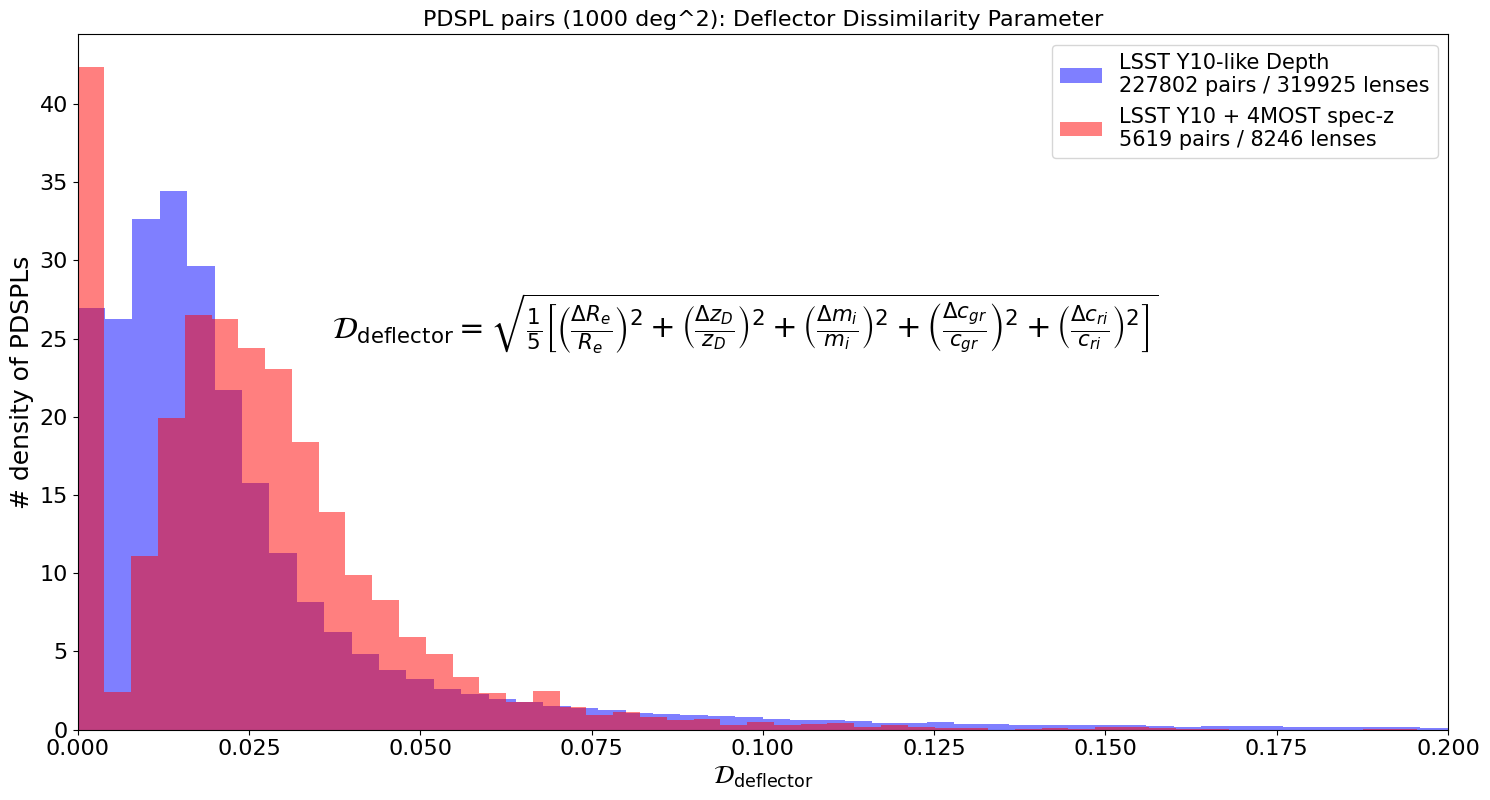

In [21]:
## deflector dissimilarity parameter plot

fig, ax = plt.subplots(figsize=(15, 9))

colors = ['orange', 'blue', 'red']

indexes_to_plot = [1, 2]

for i, (pairs_table, label, data_table, color) in enumerate(

    zip(
        [pairs_table_1yr, pairs_table_10yr, pairs_table_4MOST],
        ['LSST Single Visit Depth', 'LSST Y10-like Depth', 'LSST Y10 + 4MOST spec-z'],
        [lsst_1_yr_GGL_table, lsst_10_yr_GGL_table, lsst_4MOST_GGL_table],
        colors
    )
):
    if i not in indexes_to_plot:
        continue

    print(f'Plotting for {label} with {len(pairs_table)} pairs')

    estimator = np.sqrt(
        (
        (pairs_table['rel_diff_z_D'])**2
        + (pairs_table['rel_diff_R_e'])**2 
        + (pairs_table['rel_diff_mag_D_i'])**2
        + (pairs_table['rel_diff_color_D_gr'])**2
        + (pairs_table['rel_diff_color_D_ri'])**2
        )/5
    )

    # limit max upto 0.2 for better visualization
    estimator = estimator[estimator < 0.2]

    ax.hist(
        estimator, bins=50, color=color, alpha=0.5, density=True,
        label=f'{label}\n{len(pairs_table)} pairs / {len(data_table)} lenses'
    )

ax.set_xlabel(r'$\mathcal{{D}}_{\rm deflector}$', fontsize=18)
ax.set_ylabel('# density of PDSPLs', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlim(0, 0.2)
ax.set_title('PDSPL pairs (1000 deg^2): Deflector Dissimilarity Parameter', fontsize=16)
ax.legend(fontsize=15)

# Add definition as LaTeX above plot
fig.text(
    0.5, 0.5,
    r'$\mathcal{{D}}_{\rm deflector} = \sqrt{\frac{1}{5}\left[\left(\frac{\Delta R_e}{R_e}\right)^2 + \left(\frac{\Delta z_D}{z_D}\right)^2 + \left(\frac{\Delta m_i}{m_i}\right)^2 + \left(\frac{\Delta c_{gr}}{c_{gr}}\right)^2 + \left(\frac{\Delta c_{ri}}{c_{ri}}\right)^2\right]}$',
    ha='center', va='bottom', fontsize=22
)

fig.tight_layout(rect=[0, 0, 1, 0.9])  # leave space at top for definition


In [22]:
pairs_table['rel_diff_z_D', 'rel_diff_sigma_v_D', 'rel_diff_R_e', 'rel_diff_mag_D_i', 'rel_diff_color_D_gr', 'rel_diff_color_D_ri']

<Table length=5619>
     rel_diff_z_D       rel_diff_sigma_v_D   ...  rel_diff_color_D_ri 
       float64               float64         ...        float64       
--------------------- ---------------------- ... ---------------------
                  0.0 -0.0011468453754798495 ...                   0.0
                  0.0                    0.0 ...                   0.0
 0.000683660850268697  -0.029270122350695545 ... -0.017805987058602743
  0.09124057283511851     0.1092023237830861 ...    0.0296464639685217
 0.016296171197350384  -0.010725136425755406 ... -0.004548511346701224
                  0.0 -0.0002729522047648645 ...                   0.0
-0.019608337298145793    0.05567426846576107 ...  -0.00813029790702064
-0.006508751412343324    0.04056177828179674 ...   0.01508945686402401
-0.043733762933732705   -0.06681891878335514 ... -0.061942652021117685
                  ...                    ... ...                   ...
 -0.03851588154197558  -0.023436870702680516 ...   0.02784032163097079
-0.023253390184189784  -0.004777441791399762 ...   -0.0551217308079395
0.0038709526967373132   0.006615364221463044 ... -0.012141521533934583
                  0.0                    0.0 ...                   0.0
                  0.0                    0.0 ...                   0.0
 -0.01953151952259567   -0.13810621008654975 ... -0.010304151089967238
   0.0475470950510261   -0.12099740359087506 ...  -0.03911617600266088
  0.07100651765652154    0.08490509785538612 ...  0.010842999830144036
 0.016815745847174313   0.027806838768495906 ...  -0.03316618924104409
 0.004492498438877316   0.030891156845983102 ...  0.009316293944097512

In [ ]:
np.unique(GGL_data_table[lsst_4MOST_mag_depth_mask]['z_D'])

<Column name='z_D' dtype='float64' length=174131>
0.09478626100159085
0.09957185525436509
0.10810877191097017
0.11148330036070185
0.11307667288257063
 0.1197214319724382
0.12047557628856939
 0.1296800290990912
0.13245600052891762
0.13426111627754408
 0.1386044120670801
0.14073410478869683
                ...
 2.4994058831448975
 2.4994863495875634
  2.499573558625508
  2.499584454451683
 2.4995956753719724
  2.499689615678387
 2.4997044447190526
 2.4997316632312967
 2.4997327097587076
 2.4998097057614483
 2.4998713189652277